In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install -q condacolab
  import condacolab
  condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:45
🔁 Restarting kernel...


NeMo's Inverse Text Normalization (ITN) module uses Weighted Finite State Transducers (WFST) to deploy grammars for efficient text downstream ASR processing. In this tutorial, you will learn to build a normalization grammar from the ground up to use in your own text processing tasks.

# WFSTs

WFSTs are a form of [Finite State Machine](https://en.wikipedia.org/wiki/Finite-state_machine) used to graph relations between regular languages (or [regular expressions](https://en.wikipedia.org/wiki/Regular_expression)). For our purposes, they can be defined by two major properties:

1. Mappings between accepted input and output expressions for text substitution
2. Path weighting to direct graph traversal

For example, consider a simple normalization task of mapping the word "cent" (French for "one hundred") to the numerical representation `100`.  We would begin with the standard FSA representation of the regex `/cent/`:

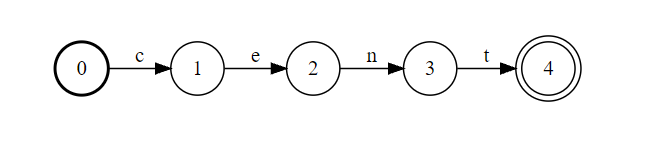

And then create a mapping to the text string `100`:

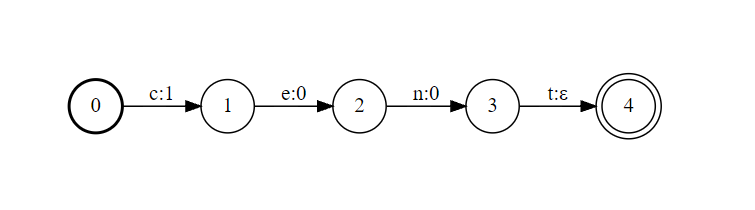

*Note: Null characters are expressed as `ε` by convention*

This would give us a WFST with universal path weights. (By default, `pynini` uses [tropical semirings](https://en.wikipedia.org/wiki/Tropical_semiring) for arcs, giving each arc a default weight of `0`.)

Now, let us consider expanding the model so that it will also accept the plural form of "cents." (That is, our regex would be `/cents?/`.) A simple solution would be to simply append a mapping from ε to "s". (For demonstration we assume closure over all characters.)

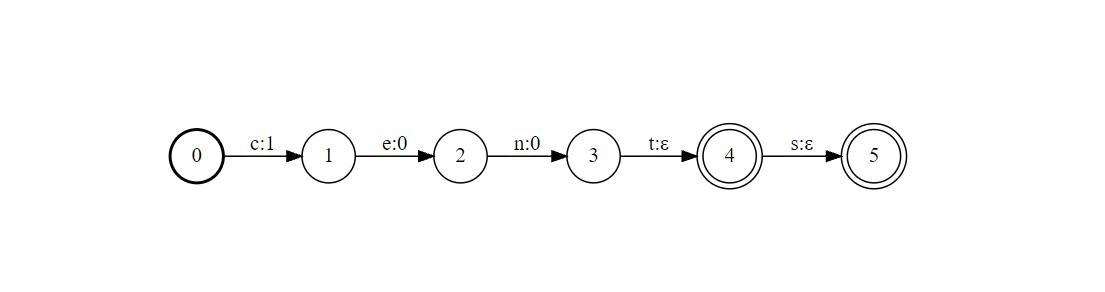

However this would make our graph [non-deterministic](https://en.wikipedia.org/wiki/Nondeterministic_algorithm) - have multiple possibilities for termination. Now an input of "cents" could have the outcome of `100` or `100s` when only one is correct. 

To correct this, we may add a new end state and a weight to the path that accepts the input without `s`:

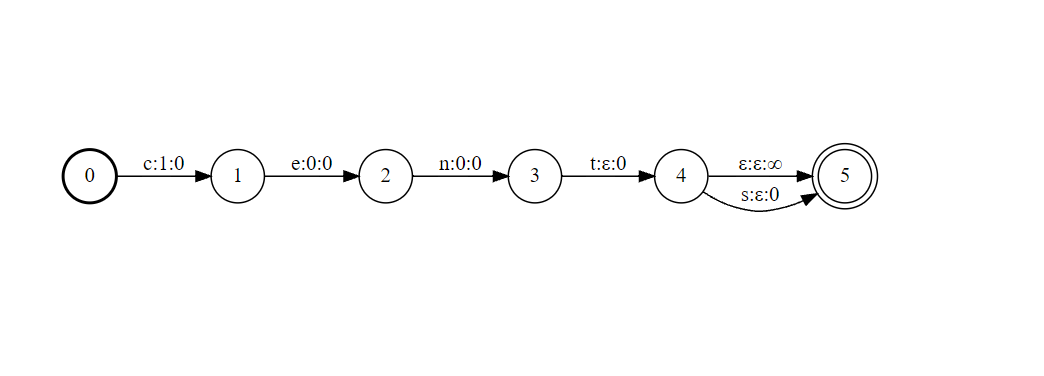

Now, we may guarantee an ideal mapping by relying on a shortest-path (smallest-weight) heuristic: traversal of the graph will prioritize deleting "s", only accepting "cent" as input when it has no other option. As such, we've now removed the undesired output `100s` while preserving determinancy in string mapping.   

This use of weights to ensure predictable behavior allows WFSTs to exploit the efficiency of standard graph traversal algorithms while also maintaining versatility. 

## Further Reading

If you wish to learn more about WFSTs, you may wish to consult the following:
- [Pynini Documentation](https://www.openfst.org/twiki/bin/view/GRM/PyniniDocs)
- [K. Gorman, Pynini: A Python library for weighted finite-state grammar compilation](https://aclanthology.org/W16-2409.pdf)
- [Jufasky and Martin, *Natural Language Processing*, Ch. 2](https://web.stanford.edu/~jurafsky/slp3/2.pdf)
- NeMo's [Text Normalization](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/text_processing/Text_Normalization.ipynb) or [Inverse Text Normalization](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/text_processing/Inverse_Text_Normalization.ipynb) tutorials

# NeMo ITN

Following [Google's Kestrel] framework, NeMo deploys two composite WFSTs for text normalization. They are as follows:
1. A *classifier* to label potential tokens by 'semiotic class' (e.g. currency, ordinal number, street address)
2. A *verbalizer* to render a tagged token in conventional written form

For example, consider the sentence: <<le premier juillet il a mangé trente-cinq pommes>>

The tokenizer would identify the following tokens:

`["le" ,"premier", "juillet", "il", "a", "mangé", "trente-cinq", "pommes"]`

and provide each a class token: 

- `tokens { name: "le" }`
- `tokens { date { day: "1" month: "juillet" } } `  
- `tokens { name: "il" }` 
- `tokens { name: "a" }` 
- `tokens { name: "mangé" }`
- `tokens { cardinal { integer: "35" } }` 
- `tokens { name: "pommes" }`

These tokens are then passed to a 'verbalizer' WFST, which renders each token in a conventional written form:

- `tokens { name: "le" }` -> `le` 
- `tokens { date { day: "1" month: "juillet" } } ` -> `1ᵉʳ` 
- `tokens { name: "il" }` -> `juillet`
- `tokens { name: "il" }` -> `il` 
- `tokens { name: "a" }` -> `a`
- `tokens { name: "mangé" }` -> `mangé` 
- `tokens { cardinal { integer: "35" } }` -> `35` 
- `tokens { name: "pommes" }` -> `pommes`

and merged into a normalized string:

`le 1ᵉʳ juillet il a mangé 35 pommes`

A few things to note: 
- NeMo assumes no punctuation (unless explicitly provided in the grammar) and all lower casing to ease integration with upstream ASR.
- The `name` class token is default for any token that does not require normalization. It will be left 'as is.'
- You may note how the tokenizer performed the conversion of `premier` to `1` while the verbalizer normalized `1` -> `1ᵉʳ`. Such decisions are implementation dependent and will vary depending on preference and language. (That is, normalization from `premier` -> `1ᵉʳ` could have been a tokenization step.)
- By default, NeMo ITN will create several permutations of each token to ease normalization. To prevent this and avoid ambiguity in verbalizer input, tokens can be assigned a `preserve_order` attribute to prevent permutation. (e.g. `tokens { date { day: "1" month: "juillet" preserve_order: true } }` (We will discuss this later in the tutorial.)

# Getting Started


To begin tokenizer development, first [install NeMo from source](https://github.com/NVIDIA/NeMo).

In [2]:
BRANCH = 'r1.4.0'
!pip install pytorch-lightning==1.5.0rc0
!git clone -b $BRANCH https://github.com/NVIDIA/NeMo.git
#!git clone https://github.com/NVIDIA/NeMo
%cd NeMo
!./reinstall.sh

     |████████████████████████████████| 967 kB 3.9 MB/s 
     |████████████████████████████████| 829 kB 38.7 MB/s 
     |████████████████████████████████| 40 kB 5.1 MB/s 
     |████████████████████████████████| 329 kB 56.6 MB/s 
     |████████████████████████████████| 125 kB 57.1 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:41tcmalloc: large alloc 1147494400 bytes == 0x559859548000 @  0x7fb113b2f615 0x55982005a67c 0x55982012e98b 0x55982005b1a2 0x5598200cd6c4 0x5598200cda9d 0x5598200f4544 0x55982003baf2 0x55982006a030 0x5598200cd9c8 0x5598200f874a 0x55982003baf2 0x55982006a030 0x5598200cd9c8 0x5598200f51d9 0x5598200bd54f 0x5598200f4789 0x5598200bd54f 0x5598200f4789 0x5598200bd54f 0x5598200f4789 0x55982003cead 0x55982005bc4e 0x55982013be99 0x5598200cca5b 0x5598200cdb59 0x5598200f44ac 0x55982003baf2 0x55982006a030 0x5598200cd9c8 0x5598200f51d9
     |████████████████████████████████| 881.9 MB 17 kB/s 
     |████████████████████████████████| 15.7 MB 55 kB/s 
    

Cloning into 'NeMo'...
remote: Enumerating objects: 75775, done.
remote: Counting objects: 100% (12241/12241), done.
remote: Compressing objects: 100% (3459/3459), done.
remote: Total 75775 (delta 9660), reused 11044 (delta 8750), pack-reused 63534
Receiving objects: 100% (75775/75775), 206.23 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (55417/55417), done.
/content/NeMo
Uninstalling stuff
Found existing installation: pytorch-lightning 1.5.0rc0
Uninstalling pytorch-lightning-1.5.0rc0:
  Successfully uninstalled pytorch-lightning-1.5.0rc0
     |████████████████████████████████| 946 kB 2.6 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
  Using cached pytorch_lightning-1.5.0rc0-py3-none-any.whl (967 kB)
Installing nemo and nemo_text_processing
Obtaining file:///content/NeMo
     |████████████████████████████████| 12.7 

Then navigate to 
`nemo_text_processing/inverse_text_normalization` and create a directory for your desired language and subdirectories
for `taggers` and `verbalizers`. You may also wish to create a `data` subdirectory to ease navigation.

In [4]:
LANGUAGE= "fr" # Change this to your desired language


In [5]:
%cd nemo_text_processing/inverse_text_normalization/
!mkdir {LANGUAGE}
!mkdir "{LANGUAGE}/taggers"
!mkdir "{LANGUAGE}/verbalizers"
!mkdir "{LANGUAGE}/data"
%cd {LANGUAGE}
!pwd && ls

[Errno 2] No such file or directory: 'nemo_text_processing/inverse_text_normalization/'
/content/NeMo/nemo_text_processing/inverse_text_normalization/fr
/content/NeMo/nemo_text_processing/inverse_text_normalization/fr/fr
/content/NeMo/nemo_text_processing/inverse_text_normalization/fr/fr
data  taggers  verbalizers


## GraphFst and Utils

All WFSTs deployed in NeMo inherit from the `GraphFst` class in `nemo_text_processing.text_normalization.en.graph_utils`.
While in most cases you can simply import from the pre-existing `graph_utils` you may find it helpful for deployment to keep a copy 
in your working directory for language specific edits. (For example, we will be utilizing `nemo_text_processing.text_normalization.en.graph_utils` as it provides some language-specific helper functions.)

You may also wish to keep a copy of `utils.py` (found in each language folder in nemo_text_processing/inverse_text_normalization)
in your working directory to assist with pathing. (Make sure to adjust the imports towards your language.)

In [4]:
!cp ../../text_normalization/en/graph_utils.py .
!cp ../../text_normalization/en/utils.py .
% cd ../../..

/content/NeMo


## WFST Classes

NeMo ITN's base languages currently support only the following semiotic classes to permit integration with Sparrowhawk deployment. 

- CARDINAL
- DATE
- DECIMAL
- FRACTION
- MEASURE
- MONEY
- NAME
- PUNCTUATION
- ORDINAL
- TIME
- ELECTRONIC
- TELEPHONE

For this tutorial, we will be focusing on the following classes:
- CARDINAL
- ORDINAL
- DECIMAL
- MONEY
- TIME
- NAME

While not comprehensive, these classes will provide enough foundation and exposure to edge cases that you will feel comfortable constructing for other cases.

**NOTE**: *If you intend to only develop for personal use with NeMo, you may rename these classes as desired. However, Sparrowhawk integration
REQUIRES use of only these tags and their assigned attributes. For list of Sparrowhawk tokens and attributes, see (Sparrowhawk link [link text](https://github.com/yzhang123/sparrowhawk/blob/test/src/proto/semiotic_classes.proto))*

# Cardinal WFST

The vast majority of ITN tasks require the ability to recognize and normalize numbers. As such, we will begin with developing a classifier and verbalizer for cardinal (integer) numbers. (e.g. `-3,-2,-1,0,1,2,3,4,5....99,100,101...`)

We will first import the NeMo text processing library and `pynini` (a python library for efficient WFST construction and traversal, installed with NeMo-toolkit by default). 

## Grammar

In [3]:
import pynini
import nemo_text_processing

We will also import the the `pynutil` module for access to some extra functionality, along with writing a simple helper function for printing `pynini` graphs through the previously discussed 'shortest-path' heuristic.

In [4]:
from pynini.lib import pynutil

In [5]:
def apply_fst(text, fst):
  """ Given a string input, returns the output string
  produced by traversing the path with lowest weight.
  If no valid path accepts input string, returns an
  error.
  """
  try:
     print(pynini.shortestpath(text @ fst).string())
  except pynini.FstOpError:
    print(f"Error: No valid output with given input: '{text}'")

### Digits

We will begin by first constructing a Cardinal WFST, using French as an example language. While your target language will obviously differ greatly from our example, you will likely find some several similarities, such as:
- Use of a (semi) regular decimal (base-10) counting system. (A common - but not universal - feature of natural languages.)
- Incoporation of several irregularities requiring contingencies in our WFST construction. (e.g. a psuedo vigesimal (base-20) series.)
- Use of gender and number agreement in enumeration.


We shall begin with the first decimal place. As these numbers serve as the building blocks for the rest of our WFST, we shall begin by explicitly calling their WFST mappings with `pynini.string_map`:

In [6]:
zero = pynini.string_map([("zéro","0")]) # French only pronounces zeroes as stand alone
digits = pynini.string_map([ # pynini function that creates explicit input-output mappings for a WFST
				("un","1"),
				("une","1"),
				("deux","2"),
				("trois","3"),
				("quatre","4"),
				("cinq","5"),
				("six","6"),
				("sept","7"),
				("huit","8"),
				("neuf","9")
])

We may also simply write a `tsv` file in a separate data folder 

In [7]:
### Example digits.tsv file. ERROR IF RUN
zéro	0
un	1
une	1
deux	2
trois	3
quatre	4
cinq	5
six	6
sept	7
huit	8
neuf	9

SyntaxError: ignored

and import with `string_file`

In [8]:
# ERROR IF RUN
digits = pynini.string_file("data/digits.tsv")

# If utils.py is in working directory you may also use `get_abs_path`, which will
# always call paths relative to your {LANGUAGE} directory.
from nemo_text_processing.inverse_normalization.{LANGUAGE}.utils import get_abs_path
digits = pynini.string_file(get_abs_path("data/digits.tsv"))

SyntaxError: ignored

While we will use `string_map` throughout this tutorial, please note that NeMo employs the later option for maintainability and recommends its use instead.

### Teens

Let us consider our next set of numbers:
- 10 - dix
- 11 - onze
- 12 - douze
- 13 - treize
- 14 - quatorze
- 15 - quinze
- 16 - seize
- 17 - dix-sept
- 18 - dix-huit
- 19 - dix-neuf

Lke before, we can simply use `string_map` to compose a WFST for them. But note how there is some redundancy in the number set: `17`, `18`, and `19` are all of the form `dix + digit`. It would be more efficient simply to reuse our prior WFST in these cases than simply creating new arcs, states, and weights. 

We can achieve this using pynini's string concatenation function to extend the accepted input strings. First we will create an WFST for `11-16`.

In [9]:
teens = pynini.string_map([
				("onze","11"),
				("douze","12"),
				("treize","13"),
				("quatorze","14"),
				("quinze","15"),
				("seize","16"),
])

Now, we will create a `tens` WFST that is responsible for mapping all instances of "dix" and concatenate it with the prior `digits` WFST. (Deleting any possible hyphens in-between.)

In [10]:
tens = pynini.string_map([("dix", "1")])
delete_hyphen = pynutil.delete("-").ques # equivalent to deleting /-?/

graph_tens = tens + delete_hyphen + digits

We now can combine the `teens` and `graph_tens` WFST together through the union operation, allowing our choice of either graph.

In [11]:
graph_tens_and_teens = graph_tens | teens

Let's see if it works through the string function:

In [12]:
apply_fst("dix-huit", graph_tens_and_teens)
apply_fst("seize", graph_tens_and_teens)
apply_fst("dix", graph_tens_and_teens)

18
16
Error: No valid output with given input: 'dix'


The first two worked, but why did we get an error with "dix"? If you look back, you'll notice that while our graph has a mapping from "dix" to `1` - the concatenation with `digits` makes the assumption that some input from those strings will follow. That is, we left no opportunity for an *omission* of `digits`.



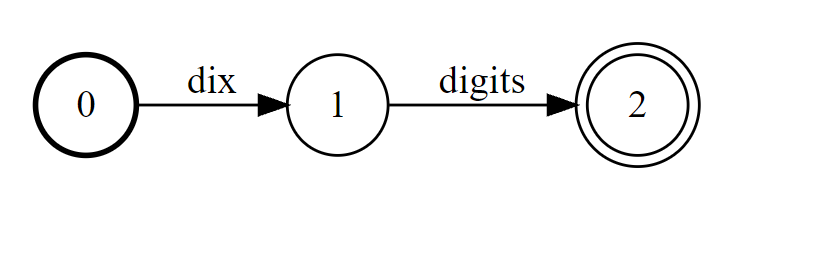

You may also note that this issue would hold also if we wanted to normalize only digits - our graph would error out since it's expecting a `tens` or input first. 


We can fix both of these problems by allowing an option to simply insert a zero without any extra input. (Much like our `/cents?/` example.)

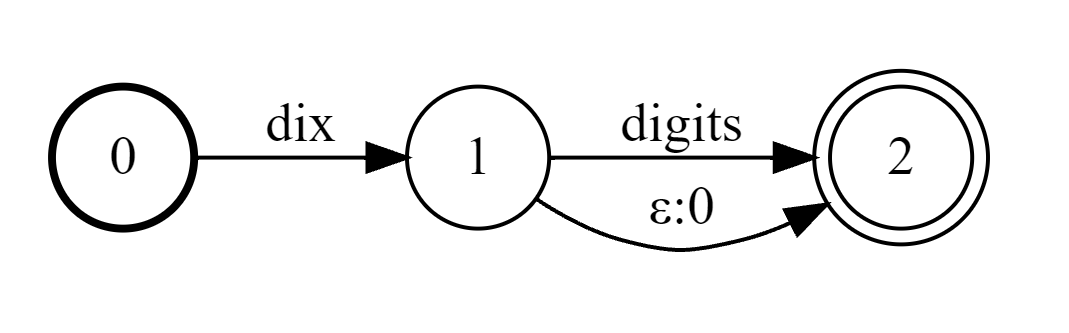

This may be accomplished through use of the `pynutil.insert` function:

In [13]:
graph_digits = digits | pynutil.insert("0") # inserts zero if no digit follows

And for `graph_tens`:

In [14]:
tens = tens | pynutil.insert("0") | tens + delete_hyphen
graph_tens = tens + graph_digits

Bringing everything together:

In [15]:
graph_teens_and_tens = graph_tens | teens
graph_all = graph_teens_and_tens | zero 

Let us now check our tests:

In [16]:
apply_fst("dix-huit", graph_all) 
apply_fst("seize" , graph_all)
apply_fst("dix" , graph_all) 
apply_fst("une" , graph_all) 
apply_fst("trois" , graph_all) 
apply_fst("quatre" , graph_all) 
apply_fst("zéro" , graph_all)

18
16
10
01
03
04
0


Now we have no more error - albeit at the cost of leading zeroes. (We will take care of this later in the section.)

### Tens

Now that we've taken care of the teens, we can proceed with the rest of the tens. Like many languages, French employs a (fairly) regular schema of: `tens digit + ones digit` for 20-100. Indeed, we can summarize 20-69 in the following template:

- 20 - vingt
- 21 - vingt-et-un
- 22 - vingt-deux
- 23 - vingt-trois
- 24 - vingt-quatre
- 25 - vingt-cinq
- 26 - vingt-six
- 27 - vingt-sept
- 28 - vingt-huit
- 29 - vingt-neuf
- 30 - trente
- 31 - trente-et-un
- 32 - trente-deux
- 33 - trente-trois
...
- 40 - quarante
...
- 50 - cinquante
...
- 60 - soixante
...

Expanding `tens` is fairly easy to accomodate this template: we simply extend our earlier `string_map` for the new terms in the 'tens place.' From there, we once again concatenate the `digits` WFST (along with a simple WFST to delete the occurence of the '-et-' term that occasionally occur.)

In [17]:
tens = pynini.string_map([
				("dix", "1"),
				("vingt","2"),
				("trente","3"),
				("quarante","4"),
				("cinquante","5"),
				("soixante","6"),
		])

graph_et = pynutil.delete("-et-")

tens = tens | pynutil.insert("0") | tens + pynutil.delete("-") | tens + graph_et

graph_tens = tens + graph_digits
graph_teens_and_tens = graph_tens | teens
graph_all = graph_teens_and_tens | zero 

#### Special Cases: 70-99

However, things get tricky once we go beyond the 60s. Here, standard French possesses a notorious psuedo-vigecimal (base-20) system. For numbers 70-99:

- 70 - soixante-dix <- Literally in English: "sixty-ten"
- 71 - soixante-et-onze <- Literally in English: "sixty-and-eleven"
- 72 - soixante-douze
- 73 - soixante-treize
- 74 - soixante-quatorze
- 75 - soixante-quinze
- 76 - soixante-seize
- 77 - soixante-dix-sept
- 78 - soixante-dix-huit
- 79 - soixante-dix-neuf
- 80 - quatre-vingts <- Literally in English: "four-twenties"
- 81 - quatre-vingt-un
- 82 - quatre-vingt-deux
- 83 - quatre-vingt-trois
- 84 - quatre-vingt-quatre
- 85 - quatre-vingt-cinq
- 86 - quatre-vingt-six
- 87 - quatre-vingt-sept
- 88 - quatre-vingt-huit
- 89 - quatre-vingt-nuef
- 90 - quatre-vingt-dix <- Literally in English: "four-twenties-ten"
- 91 - quatre-vingt-onze
- 92 - quatre-vingt-douze
- 93 - quatre-vingt-treize
- 94 - quatre-vingt-quatorze
- 95 - quatre-vingt-quinze
- 96 - quatre-vingt-seize
- 97 - quatre-vingt-dix-sept
- 98 - quatre-vingt-dix-huit
- 99 - quatre-vingt-dix-neuf

As before, we want to take advantage of as much redundancy as we can without creating additional ambiguities that will impede graph traversal. 

We first note that - despite repeating prior words - "quatre-vingt" can be mapped to `8` without introducing ambiguity. This is because, despite "quatre" and "vingt" being present in our prior graphs, our WFST has no pathing for them in this exact order. As such, we can simply add it to `tens` and immediately improve our coverage for 81-89.   

In [18]:
tens = pynini.string_map([
				("dix", "1"),
				("vingt","2"),
				("trente","3"),
				("quarante","4"),
				("cinquante","5"),
				("soixante","6"),
        ("quatre-vingt", "8")
		])
tens = tens | pynutil.insert("0") | tens + delete_hyphen | tens + graph_et
graph_tens = tens + graph_digits
graph_teens_and_tens = graph_tens | teens
graph_all = graph_teens_and_tens | zero 

Of course, now we permit the occurence of:

In [19]:
apply_fst("quatre-vingt", graph_all)


80


which is invalid (French uses the plural "quatre-vingt**s**" here.) 

Should we alter the grammar because of this? Such a decision will largely be dependent on your intended implementation and design aims. If you see the question of 'legal' tokens as a responsibility of your upstream model, then there is no need for any alteration: "quatre-vingt" as a standalone token will simply not occur, so there is no input to be concerned with.

However, if your ITN grammars are developed for an environment with low-fidelity ASR and/or where mistaken transcriptions incur heavy loss (e.g. ASR for driving directions, telephone-numbers, banking) then you may wish to err on the side of caution.

If we wanted to go for the latter, we would want to mark that "quatre-vingts" maps **only** to `80`. 

In [20]:
quatre_vingt_plural = pynini.string_map([
        ("quatre-vingts", "80")
		])

And that "quatre vingt" can only accompany non-zero digits:

In [21]:
quatre_vingt_singular = pynini.string_map([
        ("quatre-vingt-", "8") # Note that the hyphen can be assumed now
		])
graph_digits_without_zero = pynini.string_map([
				("un","1"),
				("une","1"),
				("deux","2"),
				("trois","3"),
				("quatre","4"),
				("cinq","5"),
				("six","6"),
				("sept","7"),
				("huit","8"),
				("neuf","9")
])
graph_eighties = (quatre_vingt_singular + graph_digits_without_zero) | quatre_vingt_plural

For the `70s` and `90s`, we would likewise need to form exclusive configurations for their number series, rewriting digits to recognize "onze", "douze", "treize"... as `1,2,3....` (Note, we'll have to separate `71` and `91` to manage "soixante-**et**-onze" vs. "quatre-vingt-onze".)

In [22]:
seventy_and_ninety = pynini.string_map([
        ("soixante-dix", "70"),
        ("quatre-vingt-dix", "90"),
		])

seventy_and_ninety_tens = pynini.string_map([
        ("soixante-", "7"),
        ("quatre-vingt-", "9"),
		])

seventy_and_ninety_one = pynini.string_map([
        ("soixante-et-onze", "71"),
        ("quatre-vingt-onze", "91"),
		])

seventy_and_ninety_digits = digits = pynini.string_map([                                                   
				("douze","2"),
				("treize","3"),
				("quatorze","4"),
				("quinze","5"),
				("seize","6"),
				("dix-sept","7"), # For 97-99, digits are used as normal.
				("dix-huit","8"),
				("dix-neuf","9")
])

graph_seventies_and_nineties = (seventy_and_ninety_tens + seventy_and_ninety_digits) | seventy_and_ninety | seventy_and_ninety_one 

Now we union them with our original `tens` series:

In [23]:
tens = pynini.string_map([
				("dix", "1"),
				("vingt","2"),
				("trente","3"),
				("quarante","4"),
				("cinquante","5"),
				("soixante","6"),
		])
tens = tens | pynutil.insert("0") | tens + delete_hyphen | tens + graph_et

graph_tens = tens + graph_digits
graph_tens_with_special_cases = graph_tens | graph_seventies_and_nineties | graph_eighties
graph_teens_and_tens = graph_tens_with_special_cases | teens
graph_all = graph_teens_and_tens | zero 

Making sure test cases work:

In [24]:
apply_fst("quatre-vingt-treize" , graph_all)
apply_fst("quatre-vingts", graph_all)
apply_fst("quatre-vingt-deux", graph_all)

93
80
82


And the other cases fail as expected:

In [25]:
apply_fst("quatre-vingt", graph_all)

Error: No valid output with given input: 'quatre-vingt'


Of course, there are other ways we could have reconfigured the grammar: we could simply make specific graphs for multiples of ten (`10,20,30..`) and all cases where "-et-" occurs (`21,31,41,51...91`). 

But this ignores a more important question: was any of this necessary in the first place? All these extra grammars did was simply expand coverage for thirty additional cardinals. And they still didn't exclude all faulty inputs! Note the following cases:

In [26]:
apply_fst("dix-une", graph_all)  # supposed to be "onze"
apply_fst("dix-deux", graph_all) # supposed to be "douze"
apply_fst("vingt-un", graph_all)  # supposed to be "vingt-et-un"
apply_fst("trente-un", graph_all) # supposed to be "trente-et-un"

11
12
21
31


We *still* need to address possible edge cases!

All of this is to say that knowing your input domain before construction is imperative, as small decisions can easily determine your output range later down the line.

Indeed, if you're particularly concerned with limiting input possibilities, it may be valid simply to write all unique options within a `string_map`. While a tad inelegant, it certainly assists in controlling your outputs.

In [27]:
graph_tens_special = pynini.string_map([
				("soixante-dix", "70"),
				("soixante-et-onze","71"),
        ("soixante-douze","72"),
				("soixante-treize","73"),
				("soizante-quatorze","74"),
				("soixante-quinze","75"),
				("soixante-seize","76"),
        ("soixante-dix-sept","77"),
        ("soixante-dix-huit","78"),
				("soixante-dix-neuf","79"),
        ("quatre-vingts", "80"),
        ("quatre-vingt-un", "81"),
        ("quatre-vingt-une", "81"),
				("quatre-vingt-deux","82"),
        ("quatre-vingt-trois","83"),
        ("quatre-vingt-quatre","84"),
        ("quatre-vingt-cinq","85"),
        ("quatre-vingt-six","86"),
        ("quatre-vingt-sept","87"),
        ("quatre-vingt-huit","88"),
        ("quatre-vingt-neuf","89"),
        ("quatre-vingt-dix","90"),
        ("quatre-vingt-onze","91"),
        ("quatre-vingt-douze","92"),
        ("quatre-vingt-treize","93"),
        ("quatre-vingt-quatorze","94"),
        ("quatre-vingt-quinze","95"),
        ("quatre-vingt-sieze","96"),
        ("quatre-vingt-dix-sept","97"),
        ("quatre-vingt-dix-huit","98"),
        ("quatre-vingt-dix-neuf","99"),])

Which is more efficient? Once again, it is dependent on your language and implementation. If we simply vizualize each graph and their number of states:

In [28]:
constructed_version = (graph_seventies_and_nineties | graph_eighties)
constructed_version.num_states()

252

In [29]:
string_map_version = graph_tens_special
string_map_version.num_states()


249

We see that their number of states (graph vertexes) are almost equal. Yet, if we use `pynini.optimize` - a method that calls a suite of WFST minimization algorithms: 

In [30]:
constructed_version.optimize()
constructed_version.num_states()

107

In [31]:
string_map_version.optimize()
string_map_version.num_states()

167

We see the latter possessing a significantly larger amount of graph vertices. 

So the decision will be dependent on your ITN needs, language, concern with efficiency, and design philosophy. Further, even decisions of language dialect will have an influence. 
(e.g. Belgian, Canadian, and Swiss dialects of French will dispense with elements of the vigecimal system for the decimal schema.)

**N.B.** *For reference: while `nemo_text_processing` grammars aim to minimize invalid productions, they assume input tokens are valid strings for a target language. (e.g. The mapping of "quatre-vingt" to `80` is permitted since it is not likely to occur in a valid French string.)*  

For more information on optimization algorithms for WFSTs, please see:
- K. Gorman and R. Sproat, *Finite-State Text Processing*
- [M. Mohri,"Generic epsilon-removal and input epsilon-normalization algorithms for weighted transducers"](https://cs.nyu.edu/~mohri/pub/ijfcs.pdf)
- [M. Mohri, "Weighted automata algorithms"](https://cs.nyu.edu/~mohri/pub/hwa.pdf)
- [K. Thompson, "Programming techniques: regular expression search algorithm"](http://www.oilshell.org/archive/Thompson-1968.pdf)

### Hundreds

Moving on to the case of three digit cardinals ("hundreds"), it is likely that your chosen language becomes more regular in its schema. For instance, practically all French numbers `>100` obey the following:

- `digit_from_1_to_9 + word_for_hundred + digit_from_1_to_99`

For example:
- `203` - "deux-cent-trois"
- `530` - "cinq-cent-trente"
- `880` - "huit-cent-quatre-vingt"

As such, we can write a simple `hundreds` WFST as:

In [32]:
hundreds = graph_digits + delete_hyphen + pynutil.delete("cent") + delete_hyphen + graph_all

In [33]:
apply_fst("deux-cent-trois", hundreds)
apply_fst("huit-cent-quatre-vingts", hundreds)
apply_fst("cinq-cent-trente" , hundreds)  

203
880
530


Indeed, the use of French only presents two complications:
- French uses *only* the word "cent" for `100`. (Instead of "un cent".)
- 'Pure' multiples of a hundred (`200,300,400....`) use the plural "cents".

The second one is the easier of the two so let's start there. There are actually two options open to us. First, we could treat "cents" the same way as we did "cent" in the base case and simply delete it. From there, the lack of any following inputs will allow the WFST to insert the trailing zeroes as appropriate.

In [34]:
cents = pynini.accep("cent") | pynini.accep("cents")
hundreds = graph_digits + delete_hyphen + pynutil.delete(cents) + delete_hyphen + graph_all

Or we can use it as a queue to 'shortcut' the WFST to immediately insert zeroes.

In [35]:
graph_cents = pynini.cross("cents", "00")
hundreds = graph_digits + delete_hyphen + ((pynutil.delete("cent") + delete_hyphen + graph_all) | graph_cents)

For the case of solitary "cent", we need to make sure our output is `1` only in the case that no digit preceeds the occurence. Here we need to be confident in the structure of our WFST and that any possible ambiguity has been dealt with by this point. (Something to keep in mind as we move to the thousands.)

In [36]:
graph_cent = pynini.cross("cent", "1")
graph_hundreds_first_digit = (graph_digits + delete_hyphen + pynutil.delete(cents))  | graph_cent
graph_hundreds = graph_hundreds_first_digit + delete_hyphen + graph_all

In [37]:
apply_fst("trois-cents", graph_hundreds) 
apply_fst("cent", graph_hundreds)
apply_fst("cent-trois", graph_hundreds) 

300
100
103


### Thousands

For quite a few languages, managing the WFST for the thousands place is the last aspect to figure out, as the higher powers of ten reuse the same schema. (For those working with Chinese derived counting systems, this may require further work up to the ten thousands place.)

For French, the question of thousands is rather simple: `digits_from_1_to_999 + mille + digits_from_1_to_999`

With only the exception that any expression of one thousand drops a leading digit. 
- `1,000` -> "mille"
- `1,001` ->  "mille-un"

In [38]:
graph_one_thousand = pynini.cross("mille", "1")
graph_many_thousand = graph_hundreds + delete_hyphen + pynutil.delete("mille")

graph_thousands = (graph_one_thousand | graph_many_thousand) + delete_hyphen + graph_hundreds

In [39]:
apply_fst("cent-mille-deux-cents", graph_thousands)
apply_fst("deux-cent-mille-deux-cents", graph_thousands)

100200
200200


#### Weighting

Question: will this cover all our grammar so far? (Hint: what assumptions were made about "cent"/"cents"?)


In [40]:
apply_fst("deux-mille-un", graph_thousands)

Error: No valid output with given input: 'deux-mille-un'


Once again, we need to introduce the possibility of the prior power of ten not occuring in the string. There must be an option for simply inserting a string of `00` in place of the omitted "cent".

Further, we want to be careful with how cavalier we have been with insertions. Consider the following:

In [41]:
apply_fst("mille-cent-un", graph_thousands) # Should be 1101
apply_fst("mille-cent", graph_thousands) # 1100

1001
1000


It appears that our WFST has developed a tendency to simply 'ignore' some of these higher powers. Let us return to our code for `graph_hundreds` and `graph_thousands`. 

In [42]:
graph_cents = pynini.cross("cents", "00")
graph_cent = pynini.cross("cent", "1")
graph_hundreds_first_digit = (graph_digits + delete_hyphen + pynutil.delete(cents))  | graph_cent
graph_hundreds = (graph_hundreds_first_digit + delete_hyphen | pynutil.insert("0")) + graph_all 

graph_one_thousand = pynini.cross("mille", "1")
graph_many_thousand = graph_hundreds + delete_hyphen + pynutil.delete("mille")
graph_thousands = (graph_one_thousand | graph_many_thousand) + delete_hyphen + graph_hundreds

Recall that throughout we have provided options for simply inserting zeroes in the case of omitted numbers? That tendency has finally caught up with us. The use of our previous `graph_hundreds` in `graph_many_thousands` now allows our graph to insert a string of `0`'s without penalty. 

You may note that this is very similar to the "cents" example brought up at the beginning, presenting a similar solution. We can control this output by making it too costly to traverse unless absolutely necessary for the graph. This can be accomplished simply by appending a weight to the insertion for hundreds:

In [43]:
graph_hundreds = (graph_hundreds_first_digit + delete_hyphen | pynutil.insert("0", weight=.1)) + graph_all 

graph_one_thousand = pynini.cross("mille", "1")
graph_many_thousand = graph_hundreds + delete_hyphen + pynutil.delete("mille")
graph_thousands = (graph_one_thousand | graph_many_thousand) + delete_hyphen + graph_hundreds

In [44]:
apply_fst("mille-cent-un", graph_thousands)
apply_fst("mille-cent", graph_thousands)

1101
1100


Why choose a weight of `.1`? Quite simply: it's arbitrary. As mentioned earlier, the default graph in `pynini` is a tropical semiring, which uses the `min` function to select among two arcs for path traversal. Since all our paths so far are weight `0`, any positive value will ensure that it is a last option among path traversal. (Note, this conversely entails any negative weight path will be prioritized.)

That we chose this number as a small value comes from a place of caution: the tropical semiring uses an additive function to calculate the total weight of an entire path to traverse a WFST. As our grammars can easily become massive, this means that small weights can have major impact down the line. As such, when using weights in a localized setting, it is best to use small values to avoid unforseen escalation. 

### Higher Powers


At this point, we can propose a general heuristic with escalating to higher powers of ten: they always need a way for their absence to be accomodated in the WFST. Further, they require some weighting to prevent this absence from developing into a string of omitted values. To aviod further bumps, we'll take care of this now with `graph_thousands`.

In [45]:
graph_one_thousand = pynini.cross("mille", "1")
graph_many_thousand = graph_hundreds + delete_hyphen + pynutil.delete("mille")
graph_thousands = (graph_one_thousand | graph_many_thousand | pynutil.insert("000", weight=.001)) + delete_hyphen + graph_hundreds


For the rest of French (and many other languages), the rest of the work is simply repeating the prior pattern for the thousands element: 
`hundreds + word_for_higher_power + hundreds.....` Of course there will be some variation in this schema, but the recursion should be regular. (It is rather rare that languages appropriate unique forms for these higher counts.) 

To finish French, we can list off the following equivalent for higher powers of ten:
- `million` - "million/millions" 
- `billion` - "milliard/milliards"
- `trillion` - "billion/billions"

Like the "cent/cents" rule, these values alternate with a plural form in the case of multiples of the value. Writing them out:

In [46]:
millions = pynini.accep("million") | pynini.accep("millions")
graph_millions = ((graph_hundreds + delete_hyphen + pynutil.delete(millions) + delete_hyphen) | pynutil.insert("000", weight=.1) # We need three zeroes now
 ) + graph_thousands

In [47]:
billions = pynini.accep("milliards") | pynini.accep("milliard")
graph_billions = ((graph_hundreds +  delete_hyphen + pynutil.delete(billions) + delete_hyphen)| pynutil.insert("000",weight=.1) # We need three zeroes now
 ) + graph_millions

In [48]:
trillions = pynini.accep("billion") | pynini.accep("billions")
graph_trillions = ((graph_hundreds + delete_hyphen + pynutil.delete(trillions) + delete_hyphen) | pynutil.insert("000",weight=.1) # We need three zeroes now
 ) + graph_billions

Bringing all together:

In [49]:
graph = graph_trillions | zero

Let's try it out:

In [50]:
example = "deux-cent-milliard-quatre-million-deux-cent-quatre-vingt-onze"
apply_fst(example, graph) 

000200004000291


### Finishing Touches

Now that we have our cardinal in place, we can take care of that stylistic issue of the leading zeroes. For this, we want to develop a 'filter' that deletes all zeroes preceeding the first non-zero in the string, and leave the rest 'as is.'

First let us create the filter by calling on `NEMO_DIGIT`- a `graph_util` WFST that only permits digits as input. With it, we'll create a WFST that will delete all leading zeroes in a sting. 

In [51]:
from nemo_text_processing.text_normalization.en.graph_utils import NEMO_DIGIT

delete_leading_zeroes = pynutil.delete(pynini.closure("0")) # will delete all zeroes under closure
stop_at_non_zero = pynini.difference(NEMO_DIGIT, "0") # will only accept non-zero integers
rest_of_cardinal = pynini.closure(NEMO_DIGIT) # accepts all digits that may follow

clean_cardinal = delete_leading_zeroes + stop_at_non_zero + rest_of_cardinal
clean_cardinal = clean_cardinal | "0" # We don't want to ignore the occurence of zero

graph = graph @ clean_cardinal

ValueError: ignored

Now our WFST will output our numbers as normal:

In [ ]:
apply_fst(example, graph)

### Final Notes
We have finally formulated a grammar that will process French cardinals into numeric representation. Of course, not every grammar you write will be for French. But several of the principles we've worked through will be invaluable in your own development. Before moving on, here's a quick summary of (almost) universal points to take away for WFST construction.
- Decide at the beginning of construction the level of constraint you wish for your grammar. Is it necessary to have a specific domain or can you rely on upstream models to narrow your input possibilities for you? 
- Work iteratively upwards from the smallest place value of your numeric system. This will assist you in forming building blocks for larger values. 
- Always allow for the possibility of omission of previous place values. (Not every number in the thousands will contain mention of the hundreds place.)
- For each place value, consider how the sub-grammar will affect the preceeding and following place values. Are there exceptions that you've built into the grammar that may become problematic later on?
- Utilize weights for default insertions to limit path traversal to only final options. When doing so, use small values to avoid escalating problems in your larger grammar.

With that handled, we can move on to converting this grammar into a classifier.

## Classifier

Now that we have a grammar that will convert individual tokens into number strings, we now want to focus on building it into a classifier to properly tag candidate tokens. This requires a couple of properties:
- It recognizes any valid token and permits traversal through the WFST graph
- Conversely, it does not allow invalid tokens to traverse the WFST graph
- It properly disambiguates overlap among ambiguous cases
- It attributes the proper attributes to a classified token

While this seems like a lot, in practice this just means that your grammar will need a few more tweaks to improve exclusivity and deciding on what omissions may be necessary. (More on this later.)

NeMo ITN performs token classification through a series of `GraphFst` classes and assumes deployment of your grammars through an object that inherits from this class. As such, you will need to instantiate your grammar as a `CardinalFST` 

In [1]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import GraphFst
class CardinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="cardinal", kind="classify")
        # Rest of the grammar here
        # ....... 
        #.........

ModuleNotFoundError: ignored

While the naming convention may vary, the `name` and `kind` properties must be set accordingly to permit Sparrowhawk integration.

Further, the reulting graph must produce the classified token within the following format:
- `token { cardinal { integer: "DIGIT_STRING" } }`

This is accomplished by a simple string insertion:

In [ ]:
class CardinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="cardinal", kind="classify")
        # Rest of the grammar here
        # ....... 
        #.........
        self.fst = pynutil.insert("integer: \"") + graph + pynutil.insert("\"")

Followed by a call of the parent `GraphFst.add_tokens()` method:

In [ ]:
class CardinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="cardinal", kind="classify")
        # Rest of the grammar here
        # ....... 
        #.........
        self.fst = pynutil.insert("integer: \"") + graph + pynutil.insert("\"")
        final_graph = self.add_tokens(graph)

Which will insert the appropriate formatting.

In the event that you also wish for `CardinalFst` to indicate negative values, the optional `negative: ` property may be used.

For instance, French indicates negative values by prefacing the quantity with "moins." As such:

In [ ]:
optional_minus_graph = pynini.closure(
    pynutil.insert("negative: ") + pynini.cross("moins", "\"-\"") + " ", 0, 1
)

final_graph = optional_minus_graph + pynutil.insert("integer: \"") + graph + pynutil.insert("\"")

All together, your `CardinalFst` ultimately serves as a wrapper for your grammar, save with the addition of a few insertions to assist processing:



In [ ]:
class CardinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="cardinal", kind="classify")
        
        ### Cardinal Grammar....
        ### .....
        graph = graph_trillions | zero 

        ### Formatting grammar....
        ### .....
        graph = graph @ clean_cardinal

        ### Token insertion
        optional_minus_graph = pynini.closure(
        pynutil.insert("negative: ") + pynini.cross("moins", "\"-\"") + " ", 0, 1
          )

        final_graph = optional_minus_graph + pynutil.insert("integer: \"") + graph + pynutil.insert("\"")

        final_graph = self.add_tokens(final_graph)

        self.fst = final_graph

Let's see a demonstration. 

In [ ]:
cardinal = CardinalFst().fst

example = "moins deux-cent-quatre"

apply_fst(example, cardinal)

## Verbalizer

The verbalizer can be both the most crucial and simplest part of building each grammar. On one hand, it is the component that finalizes all of your previous work. If it is unable to properly normalize your text, everything has been for naught.

On the other hand, your previous work has vastly limited the unpredictability of your input. Recall from our initial demonstration of the classifier-verbalizer system that and input like <<le premier juillet il a mangé trente-cinq pommes>> becomes:

- `tokens { name: "le" }`
- `tokens { date { day: "1" month: "juillet" }`  
- `tokens { name: "il" }` 
- `tokens { name: "a" }` 
- `tokens { name: "mangé" }`
- `tokens { cardinal { integer: "35" } }` 
- `tokens { name: "pommes" }`

Part of the purpose of the two stage set-up is that the input space for each verbalizer is obvious: it's simply the name of its semiotic class. As such, we only need to write our grammar to recognize its class, remove tokens accordingly, and then manage the attributes of each semiotic token.

We will begin as we did with our classifier and create a class to inherit from the `GraphFST` utility class:

In [ ]:
class CardinalFst(GraphFst):
  def __init__(self):
    super().__init__(name="cardinal", kind="verbalize")

One of the useful aspects of the `GraphFst` utility is that it already posseses a built in graph that will recognize and remove semiotic tokens: `delete_tokens`. As such we need only concern ouselves with managing the properties of the Cardinal class:
- integers
- negative

Here, the desired written format of your chosen language will dictate how you proceed. For French, we have the following rules for Cardinal numbers:
- A negative sign is written before the numeral.
- Cardinal numbers representing quantities (e.g. "mille euros"/ "one thousand dollars") are written with spaces in-between every three digits. (e.g. `1 000`)
- Cardinal numbers representing place in a sequence or addresses ("page mille"/"page one thousand") are written without spacing. (`1000`)

The first property seems easy enough to handle: write a grammar that simply removes the `negative` formatting, leaving only `-`. (Recall that our Classifier only inserted the string if it was present.) 

For the final two, we may note that our intention to develop WFSTs for the Decimal, Measure, and Money classes already will cover most desired quantities. As such, we can leave the issue of spacing to those instances and let the Cardinal WFST default to the non-spacing case. (Note that this will be helpful with Time, Date, Telephone, Electronic, and Ordinal classes as they will not use the spacing format either. It is usually better to reserve specific formatting rules to other classes and let the Cardinal serve as a default.)

As such, we just need our WFST to remove the `integer` property and `negative` property (if it occurs). These can be managed through the `pynutil.delete` function, as seen in the following:


In [1]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import (
    NEMO_DIGIT,
    delete_space, # Helper WFST that deletes spaces. 
)

class CardinalFst(GraphFst):
  def __init__(self):
    super().__init__(name="cardinal", kind="verbalize")
    
    # Removes the negative attribute and leaves the sign if occurs
    optional_sign = pynini.closure(
            pynutil.delete("negative:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.accep("-")
            + pynutil.delete("\"")
            + delete_space,
            0,
            1,
        )
    
    # removes integer aspect
    graph = (
            pynutil.delete("integer:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1) # Accepts at least one digit
            + pynutil.delete("\"")
        )
      
    graph = optional_sign + graph # concatenates two properties

    delete_tokens = self.delete_tokens(graph) # removes semiotic class tag

    self.fst = delete_tokens.optimize()

ModuleNotFoundError: ignored

Let's see if it will properly render a given token:

In [ ]:
cardinal = CardinalFst().fst
example = 'cardinal { negative: "-" integer: "204" }'

apply_fst(example, cardinal)

That's it! We've now completed all aspects of our `CardinalFst` from grammar writing to Verbalization. While we still have quite a few semiotic classes left, you will find that they build off the `CardinalFst` quite easily, making progression much simpler and straightforward.

Before proceeding, there are two things to note:
- `delete_tokens` is called on the completed graph, despite the token class occuring first in the tokenized string. This is because the function intersects with an initial WFST that deletes the tags. As such, the function must be passed a completed graph.
- Earlier in the tutorial we noted that NeMo ITN permutates all WFSTs unless the `preserve_order` tag is passed as part of the Classifier. This allows you to ignore possible variation in designing the verbalizer and focus on whatever form of processing is easiest for the grammar. That is, the decision to process the `negative` property before the `integer` property is not chosen because of a consequence of the French language but instead because it is easier to write out with `pynini`. 
- Conversely, if your language is completely invariant in this regard, it may be more efficient to pass `preserve_order` through the Classifier and manage the property here in the Verbalizer. This allows NeMo ITN to avoid building states and arcs for each permutation, reducing graph size and compiling time.

# Ordinal WFST

Ordinals is the class of numbers used for enumerating order or placement of entities in a series. In some languages, they are simply derivations of cardinal numbers. For instance, English enumerates order as `first, second, third, fourth, fifth....` After the third ordinal, they become a regular pattern of `cardinal + 'th'`.

Meanwhile, other languages may reserve specific counting systems for ordinals. For example, while Korean uses a Chinese derived counting system for several Cardinal related tasks, it uses derivations from a native counting system for ordering:

**Cardinal**/**Ordinal** = **English**
- il/cheot-jae = "First"
- i/dul-jae = "Second"
- sam/set-jae = "Third"
- sa/net-jae = "Fourth"
- o/daseot-jae = "Fifth"

If your language is of the latter variety, you will likely need to begin development of Ordinal WFST by repeating Cardinal WFST development before proceeding. (Or make it part of your previous Cardinal WFST and combining with a `union` operation.) While you can extend coverage to the level of Cardinal WFST, you will find most Ordinals to be sufficiently covered by only enumerating to a few hundreds. (e.g. Is it common in your language to speak of the "one millionth" in an order and/or write out `1,000,000th`?)

For this portion of the tutorial, we will focus on the first type of ordinals - those that primarily derived by altering Cardinals.

## Grammar

Continuing with our example language, we first begin by laying out our expected inputs and pinpointing a regular pattern to guide our WFSTs. We note the following examples:

  **English = French**
  - "first" = "premier/première"
  - "second" = "second/seconde/deuxième"
  - "third" = "troisième"
  - "fourth" = "quatrième"
  - "fith" = "cinquième"
  - "sixth" = "sixième"
  - "seventh" = "septième"

From our examples inputs, it appears that spelling of French Ordinals follows a general format of: `cardinal + ième`. The only exceptions appear to be in the case of the first and second Ordinals - for which completely different roots appear - and the fourth and the fith Ordinals - where the former drops the "e" at the end of the root (`quatre -> quatr`) and the latter appends a "u" (`cinq -> cinqu`). 

For the expected outputs, we observe the following examples:
  - "premier/première" -> `1ᵉʳ/1ʳᵉ`
  - "second/seconde" -> `2ᵈ/2ᵈᵉ`
  - "deuxième" -> `2ᵉ`
  - "troisième" -> `3ᵉ`
  - "quatrième" -> `4ᵉ`
  - "cinquième" -> `5ᵉ`
  - "sixième" -> `6ᵉ`
  - "septième" -> `7ᵉ`

It appears that the output is simply the cardinal number of the root with an associated superscript. Since we have already constructed the Cardinal WFST, this means that the job of constructing an Ordinal WFST is simply a case of recognizing the cardinal root for the input and then utilizing a preconstructed Cardinal grammar to render the proper form alongside an associated superscript. That is, our tasks are to:
- Identify the proper superscript for the ordinal
- Change the ordinal back into a cardinal
- Use the Cardinal WFST to transform the cardinal into normalized form
- Properly render the ordinal using the normalized cardinal and proper superscript

As information regarding the superscript will need to be conveyed through development of the Classifier, we will begin with creating the grammar necessary for rendering the ordinal as its cardinal root.  



### Stripping Suffixes

Since French forms Ordinals by appending a suffix to Cardinals, we should start by creating a WFST to remove the suffix. Assuming that our grammar processes one token at a time, this means that we just need an WFST that will accept all tokens that end with "ième" and then delete the suffix from that token:

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import NEMO_SIGMA # helper WFST that permits all valid utf8 characters

strip_morpheme = pynutil.delete("ième") # deletes suffix
graph_strip_morpheme = NEMO_SIGMA + strip_morpheme # accepts all strings until passed suffix, then deletes suffix

Now we can create a graph that permits all characters in a word token and deletes the ordinal suffix. (Note that this also means that the graph won't accept tokens without the suffix, helping us avoid false inputs.) 

We can now intersect this graph with our Cardinal WFST to now strip the suffixes from ordinals and treat them as cardinals.

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.taggers.cardinal import CardinalFst

graph_cardinal = CardinalFst().graph_no_exception # Component WFST used in NeMo Cardinals

graph_ordinal_regular_suffix = graph_strip_morpheme @ graph_cardinal

Let's see if it works:

In [ ]:
example = "sixième"
apply_fst(example, graph_ordinal_regular_suffix)

Now we can consider the edge cases. Beyond the first and second ordinals, French exhibits irregular behavior in the following cases:
- If the cardinal root ends with an "e", the "e" is dropped before adding the suffix (e.g. "quatrième"). 
- Cardinals ending with "cinq", "neuf", and "dix" change their endings to "cinqu", "neuv" , and "diz" before appending the suffix, respectively. 

We could start by proposing a WFST that replaces the suffix "ième" with "e" and then compose this onto the Cardinal WFST. If it is a legitimate cardinal, then there will be a path through CardinalFST and the integer will be rendered as normal. 

Meanwhile, the case of "dix", "cinq", and "neuf" would each require a distinct WFST as they are each a consequence of different rules of orthography and phonology. Like the case with "e", we could change each back to its root and then see if the CardinalWFST will permit a path with the new input. 

It is at this point that we can do a cost-benefit analysis and realize that all these cases can be managed by an explicit `string_map/string_file`:

In [ ]:
graph_root_change = pynini.string_map([("quatrième", "quatre"),
                                  ("cinquième",	"cinq"),
                                  ("neuvième",	"neuf"),
                                  ("onzième",	"onze"),
                                  ("douzième",	"douze"),
                                  ("treizième",	"treize"),
                                  ("quatorzième",	"quatorze"),
                                  ("quinzième",	"quinze"),
                                  ("seizième",	"seize"),
                                  ("trentième",	"trente"),
                                  ("quarantième",	"quarante"),
                                  ("cinquantième",	"cinquante"),
                                  ("soixantième",	"soixante"),
                                  ("septantième",	"septante"),
                                  ("huitantième",	"huitante"),
                                  ("nonantième",	"nonante"),
                                  ("millième",	"mille"),
])

We could then concatenate these with a WFST that accepts all tokens with these endings and then change the endings as desired. These will provide the cardinal roots just as effectively. 

The same can be said for "premier/première" and "second/seconde":

In [ ]:
graph_firsts = pynini.string_map([("premier", "un"),("première", "un")])
graph_seconds = pynini.string_map([("second", "deux"),("seconde", "deux")])

*Note: We graph separately to manage their different superscripts later on.*

Depending on your language of focus, the choice of implicitly reversing the root token or explicitly mapping back to root will be the most efficient, but it is worth considering both options if only to check your understanding of the language.

Putting our grammar together, we have:

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.taggers.cardinal import CardinalFst
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import NEMO_SIGMA # helper WFST that permits all valid utf8 characters

strip_morpheme = pynutil.delete("ième") # deletes suffix

graph_root_change = pynini.string_map([("quatrième", "quatre"),
                                  ("cinquième",	"cinq"),
                                  ("neuvième",	"neuf"),
                                  ("onzième",	"onze"),
                                  ("douzième",	"douze"),
                                  ("treizième",	"treize"),
                                  ("quatorzième",	"quatorze"),
                                  ("quinzième",	"quinze"),
                                  ("seizième",	"seize"),
                                  ("trentième",	"trente"),
                                  ("quarantième",	"quarante"),
                                  ("cinquantième",	"cinquante"),
                                  ("soixantième",	"soixante"),
                                  ("septantième",	"septante"),
                                  ("huitantième",	"huitante"),
                                  ("nonantième",	"nonante"),
                                  ("millième",	"mille"),
])

# Component will accept all tokens that end with desired strings
graph_get_cardinal = NEMO_SIGMA + (strip_morpheme | graph_root_change) 

graph_firsts = pynini.string_map([("premier", "un"),("première", "un")])
graph_seconds = pynini.string_map([("second", "deux"),("seconde", "deux")])

graph_get_cardinal = pynini.union(graph_firsts, graph_seconds, graph_get_cardinal) 

graph_cardinal = CardinalFst().graph_no_exception

graph_ordinal = graph_get_cardinal @ graph_cardinal

In [ ]:
apply_fst("sixième", graph_ordinal)
apply_fst("première", graph_ordinal)
apply_fst("seconde", graph_ordinal)

## Classifier

Now that we've found a way to pass the work of the Ordinal grammar back onto the Cardinal grammar, we can move onto the Classifier. Like before, we need to inherit from `GraphFst` to properly insert token formatting and required attributes. As well, we will again use the `integer` property to tag our digit string.

Indeed, the only major difference between the Ordinal Classifier and the Cardinal Classifier is the replacement of optional `negative` attribute with the `morphosyntactic_feature` attribute to indicate the superscript function.

Since we are relying on the `CardinalFst` class in our grammar, we want to consider how to instantiate an instance of it. Since our ultimate goal is to build a Classifier that unites all semiotic classes, it makes sense to simply use the `CardinalFst` that we will need to call for our ITN and pass it as an argument to our new class.

In [6]:
from nemo_text_processing.text_normalization.en.graph_utils import GraphFst

def __init__(self, cardinal: GraphFst):
        super().__init__(name="ordinal", kind="classify")

ValueError: ignored

Further, recall that our `CardinalFst` inserted its own tokens to indicate a cardinal number. Obviously, we do not wish to classify our ordinal as a cardinal. As such, we are going to call one of the composite WFSTs used to create the final CardinalFst. `graph_no_exception` simply normalizes cardinal tokens without tokenizing. (For your language ,you will need to go back to your CardinalFst to insert your instance of `graph_no_exception`. All that is necessary is using the WFST created prior to token insertion. It is recommended that you call the `optimize` method.)

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import GraphFst
class OrdinalFst(GraphFst):
  def __init__(self, cardinal: GraphFst):
          super().__init__(name="ordinal", kind="classify")
          graph_cardinal = cardinal.graph_no_exception # can be replaced

We now add in our grammar:

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import GraphFst, NEMO_SIGMA

class OrdinalFst(GraphFst):
  def __init__(self, cardinal: GraphFst):
      super().__init__(name="ordinal", kind="classify")
      graph_cardinal = cardinal.graph_no_exception # may replace

      strip_morpheme = pynutil.delete("ième") # deletes suffix

      graph_root_change = pynini.string_map([("quatrième", "quatre"),
                                ("cinquième",	"cinq"),
                                ("neuvième",	"neuf"),
                                ("onzième",	"onze"),
                                ("douzième",	"douze"),
                                ("treizième",	"treize"),
                                ("quatorzième",	"quatorze"),
                                ("quinzième",	"quinze"),
                                ("seizième",	"seize"),
                                ("trentième",	"trente"),
                                ("quarantième",	"quarante"),
                                ("cinquantième",	"cinquante"),
                                ("soixantième",	"soixante"),
                                ("septantième",	"septante"),
                                ("huitantième",	"huitante"),
                                ("nonantième",	"nonante"),
                                ("millième",	"mille"),
        ])
      
      # Component will accept all tokens that end with desired strings
      graph_get_cardinal = NEMO_SIGMA + (strip_morpheme | graph_root_change) 

      graph_firsts = pynini.string_map([("premier", "un"),("première", "un")])
      graph_seconds = pynini.string_map([("second", "deux"),("seconde", "deux")])

      graph_get_cardinal = pynini.union(graph_firsts, graph_seconds, graph_get_cardinal) 

      graph_ordinal = graph_get_cardinal @ graph_cardinal


Now we come to the `morphosyntactic_features` property - a linguistic term for aspects of a word related to grammar. If intending to deploy your WFST through Sparrowhawk, this is the only ordinal property that is permitted (outside of the universal properties like `preserve_order`) and thus must carry all information regarding how to properly normalize the ordinal. (If Sparrowhawk deployment is not necessary, you may add additional properties to the tag.)

How should we convey this information? Since the Verbalizer will be the main interface for our tags, it really does not matter - so long as we can reliably process the features. For the purposes of French, we just need `morphosyntactic_features` to decide the following:
- Insert the specific superscripts for "premier/première" or "second/seconde"
- Insert "ᵉ" otherwise

We will also introduce another aspect of French Ordinals: they can be either plural or singular, identified by the suffix "s" on input and superscript "ˢ" on output. As such, our `morphosyntactic_features` should also decide the additional property:
- Insert the plural superscript 

Since the default superscript is near universal, we will just specify this in our WFST and focus on the second and first ordinals as specific cases. We will create a `graph_morpheme` component that inserts the default superscript - indicated with a standard "e" to avoid possible encoding issues. We will then append a WFST that will graph any possible plural marker - "s" - as part the `morphosyntactic_features`. 

In [ ]:
graph_morpheme = pynutil.insert("e") # Insert e superscript
graph_plural = pynini.accep("s").ques # We create an acceptor since we must process the possible "s"

graph_morpheme_component = graph_morpheme + graph_plural

graph_morphosyntactic_features = (pynutil.insert(" morphosyntactic_features: \"") 
      + graph_morpheme_component
        )

Introducing the `integer` feature:

In [ ]:
graph_reg_ordinals = graph_get_cardinal @ graph_cardinal # Rewriting ordinals to remove the first and second ordinal.

graph_ordinal = pynutil.insert("integer: \"") + graph_reg_ordinals + pynutil.insert("\"")
graph_ordinal += graph_morphosyntactic_features

For the first and second ordinals, we can explicitly state their mappings, as these occurences are invariable. (First and second ordinals do not need to accomodate being the endings of other terms.) As such, we can just have mappings from the token to the superscripts.

In [ ]:
firsts = pynini.string_map([("premier", "er"), ("première","re")])
firsts += graph_plural # Still accepts plural marker in superscript
seconds = pynini.string_map([("second", "d"),("seconde", "de")])
seconds += graph_plural 

graph_firsts = pynutil.insert("integer: \"1\" morphosyntactic_features: \"") + firsts
graph_seconds = pynutil.insert("integer: \"2\" morphosyntactic_features: \"") + seconds

Placing them in our class:

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import GraphFst, NEMO_SIGMA

class OrdinalFst(GraphFst):
  def __init__(self, cardinal: GraphFst):
      super().__init__(name="ordinal", kind="classify")
      graph_cardinal = cardinal.graph_no_exception # may replace

      strip_morpheme = pynutil.delete("ième") # deletes suffix

      graph_root_change = pynini.string_map([("quatrième", "quatre"),
                                ("cinquième",	"cinq"),
                                ("neuvième",	"neuf"),
                                ("onzième",	"onze"),
                                ("douzième",	"douze"),
                                ("treizième",	"treize"),
                                ("quatorzième",	"quatorze"),
                                ("quinzième",	"quinze"),
                                ("seizième",	"seize"),
                                ("trentième",	"trente"),
                                ("quarantième",	"quarante"),
                                ("cinquantième",	"cinquante"),
                                ("soixantième",	"soixante"),
                                ("septantième",	"septante"),
                                ("huitantième",	"huitante"),
                                ("nonantième",	"nonante"),
                                ("millième",	"mille"),
        ])
      
      # Component will accept all tokens that end with desired strings
      graph_get_cardinal = NEMO_SIGMA + (strip_morpheme | graph_root_change) 

      # Graph will map ordinals beyond second ordinal to their cardinals
      graph_reg_ordinals = graph_get_cardinal @ graph_cardinal

      # Graphing morphosyntactic_features
      graph_morpheme = pynutil.insert("e") # Insert e superscript
      graph_plural = pynini.accep("s").ques # We create an acceptor since we must process the possible "s"

      graph_morpheme_component = graph_morpheme + graph_plural

      graph_morphosyntactic_features = (pynutil.insert(" morphosyntactic_features: \"") 
      + graph_morpheme_component
        )

      # Adding in the `integer` property:
      graph_ordinal = pynutil.insert("integer: \"") + graph_reg_ordinals + pynutil.insert("\"")
      graph_ordinal += graph_morphosyntactic_features   

      # Case of first and second ordinals
      firsts = pynini.string_map([("premier", "er"), ("première","re")])
      firsts += graph_plural # Still accepts plural marker in superscript
      seconds = pynini.string_map([("second", "d"),("seconde", "de")])
      seconds += graph_plural 

      graph_firsts = pynutil.insert("integer: \"1\" morphosyntactic_features: \"") + firsts
      graph_seconds = pynutil.insert("integer: \"2\" morphosyntactic_features: \"") + seconds

      # All together
      graph_ordinal = pynini.union(graph_ordinal, graph_firsts, graph_seconds)
      self.fst = graph_ordinal.optimize()

Trying out on some examples:

In [ ]:
cardinal = CardinalFst()
ordinal = OrdinalFst(cardinal).fst

apply_fst("premier", ordinal)
apply_fst("premiers", ordinal)
apply_fst("seconde", ordinal)
apply_fst("douzièmes", ordinal)
apply_fst("cent-cinquièmes", ordinal)



### Special Tokens

If you are particularly astute, you may have noticed that we have not closed the quotations around the `morphosyntactic_features` throughout, despite doing so for `integer`. This is not a typo, as there is one more aspect of the Classifier that must be addressed: special cases.

For your language, you may notice that there are occasional exceptions to writing rules that are signaled by a specific vocabulary token in a string. As this must be communciated to our Verbalizer, it is important that we signal this vocabulary through our Classifier. 

For French, this can occur in the normalization of centuries. When using Ordinals to indicate centuries, French commonly writes with Roman numerals. For example:
- "Fifth century" -> "cinquième siècle" -> `Vᵉ siècle`  
- "Twentieth century" -> "vintième siècle" -> `XXᵉ siècle` 

As such, we must allow our Classifier to pass on the information that "siècle" follows an ordinal to our Verbalizer, so it may normalize with Roman numerals. We accomplish this by appending a WFST that accepts special tokens that follow our Ordinals, adding them to our `morphosyntactic_features` attribute with a forward slach to delineate.

In [ ]:
special_tokens = pynini.accep("siècle")

graph_special_tokens = delete_space + pynutil.insert("/") + special_tokens # We need to delete the space in between this token and the following one.
graph_special_tokens = pynini.closure(graph_special_tokens, 0, 1)

graph_ordinal += graph_special_tokens + pynutil.insert("\"")

*Once again, it is advised to retain a tsv file in `data` to quickly append these key-words.*

Having taken care of the special case, we may now call `add_tokens` and complete the graph (fully written out below).

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import GraphFst, NEMO_SIGMA

class OrdinalFst(GraphFst):
  def __init__(self, cardinal: GraphFst):
      super().__init__(name="ordinal", kind="classify")
      graph_cardinal = cardinal.graph_no_exception # may replace

      strip_morpheme = pynutil.delete("ième") # deletes suffix

      graph_root_change = pynini.string_map([("quatrième", "quatre"),
                                ("cinquième",	"cinq"),
                                ("neuvième",	"neuf"),
                                ("onzième",	"onze"),
                                ("douzième",	"douze"),
                                ("treizième",	"treize"),
                                ("quatorzième",	"quatorze"),
                                ("quinzième",	"quinze"),
                                ("seizième",	"seize"),
                                ("trentième",	"trente"),
                                ("quarantième",	"quarante"),
                                ("cinquantième",	"cinquante"),
                                ("soixantième",	"soixante"),
                                ("septantième",	"septante"),
                                ("huitantième",	"huitante"),
                                ("nonantième",	"nonante"),
                                ("millième",	"mille"),
        ])
      
      # Component will accept all tokens that end with desired strings
      graph_get_cardinal = NEMO_SIGMA + (strip_morpheme | graph_root_change) 

      # Graph will map ordinals beyond second ordinal to their cardinals
      graph_reg_ordinals = graph_get_cardinal @ graph_cardinal

      # Graphing morphosyntactic_features
      graph_morpheme = pynutil.insert("e") # Insert e superscript
      graph_plural = pynini.accep("s").ques # We create an acceptor since we must process the possible "s"

      graph_morpheme_component = graph_morpheme + graph_plural

      graph_morphosyntactic_features = (pynutil.insert(" morphosyntactic_features: \"") 
      + graph_morpheme_component
        )

      # Adding in the `integer` property:
      graph_ordinal = pynutil.insert("integer: \"") + graph_reg_ordinals + pynutil.insert("\"")
      graph_ordinal += graph_morphosyntactic_features   

      # Case of first and second ordinals
      firsts = pynini.string_map([("premier", "er"), ("première","re")])
      firsts += graph_plural # Still accepts plural marker in superscript
      seconds = pynini.string_map([("second", "d"),("seconde", "de")])
      seconds += graph_plural 

      graph_firsts = pynutil.insert("integer: \"1\" morphosyntactic_features: \"") + firsts
      graph_seconds = pynutil.insert("integer: \"2\" morphosyntactic_features: \"") + seconds


      # Special tokens
      special_tokens = pynini.accep("siècle")

      graph_special_tokens = delete_space + pynutil.insert("/") + special_tokens # We need to delete the space in between this token and the following one.
      graph_special_tokens = pynini.closure(graph_special_tokens, 0, 1)

      graph_ordinal += graph_special_tokens + pynutil.insert("\"")

      # Finishing
      graph_ordinal = self.add_tokens(graph_ordinal)
      self.fst = graph_ordinal.optimize()


## Verbalizer

The initial part of the Ordinal Verbalizer is similar to the Cardinal WFST: we simply need to build a Verbalizer that inherits from `GraphFST` and removes the `integer` property tag. 

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import (
    NEMO_DIGIT, # Captures all digits
    NEMO_NOT_QUOTE, # Captures everything not in quotes
    GraphFst,
    delete_space,
)

class OrdinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="ordinal", kind="verbalize")
        graph_integer = (
            pynutil.delete("integer:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1)
            + pynutil.delete("\"")
        )


Now we need to manage the `morphosyntactic_features` component. The first steps seem simple enough: delete the property tag and replace the superscript indicators with the actual superscripts. 

In [ ]:
        # Create mappings for all superscripts
        superscript = pynini.union(
            pynini.cross("e", "ᵉ"),  # only delete first quote since there may be more features
            pynini.cross("d", "ᵈ"),
            pynini.cross("r", "ʳ"),
            pynini.cross("s", "ˢ"),
        )

        # Append to deletion of feature property. Note that we use plus closure for multiple superscripts.
        graph_morphosyntactic_features = pynutil.delete(" morphosyntactic_features: \"") + superscript.plus

### Romanization

Now we come to the possible Romanization component. Since we need to graph the superscript components as following the number, we want to design our graph so that `morphosyntactic_features` is the last component of the graph. However, we do not know that we need Romanization until we see the `morphosyntactic_features` component. As such, we need to design our graph that two options are available initially for an input, but only one allows full traversal.

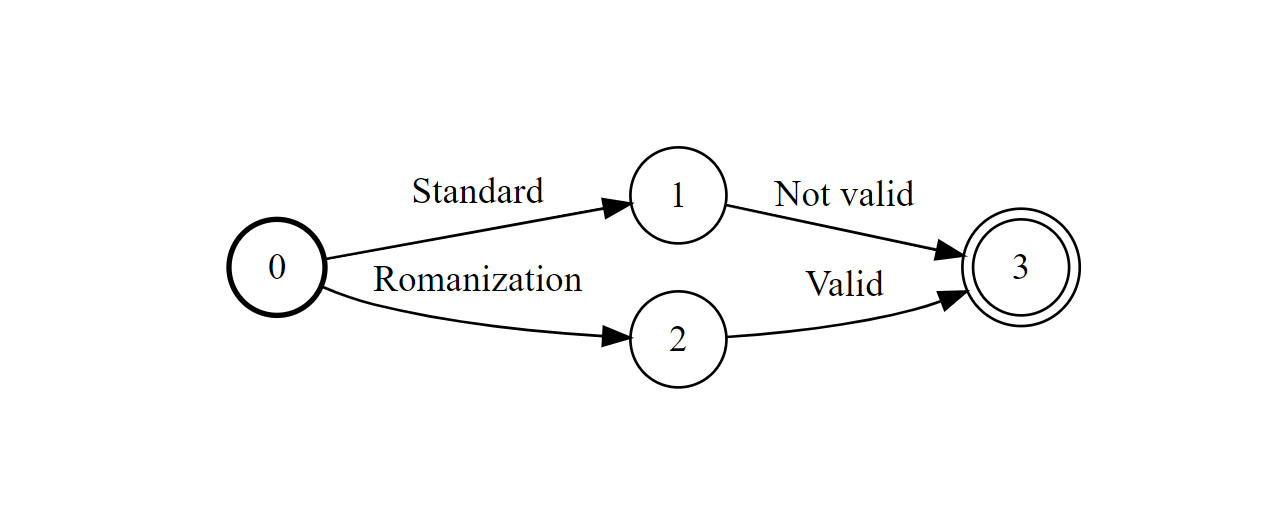

In cases where your WFST decisions are dependent on latter parts of an input string, permitting the union of two separate paths when only one is valid usually assists, as a standard pathing heuristic will only choose the valid path. 

In the case of French, this would require us to separate our Verbalizer into two parts: one for Arabic numerals and one for Roman numerals. For the Arabic WFST, we simply conclude the graph. 

In [ ]:
graph_integer = (
            pynutil.delete("integer:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1)
            + pynutil.delete("\"")
        )
graph_arabic = graph_integer + graph_morphosyntactic_features + pynutil.delete("\"")

For the Roman graph, things get a bit trickier. Ideally, we would want to build a WFST that maps each digit of `graph_arabic` to a Roman equivalent. However, consider the following examples:
- 1 -> I
- 10 -> X
- 11 -> XI
- 100 -> C
- 101 -> CI
- 110 -> CX
- 111 -> CXI

Since Roman numerals do not preserve powers of ten through digit placement, we will need to design separate FSTs for each digit position and apply them accordingly. As this can quickly become intensive, we will only work to enumerate the Ordinals from 1 to 100. (Note: We are doing this to accomodate centuries; there is little likelihood that any century beyond the 99th will be used in regular strings.)

First we design our graphs for converting from Arabic to Roman numerals:

In [ ]:
digits = pynini.string_map([("1", "I"),
                          ("2",	"II"),
                          ("3",	"III"),
                          ("4",	"IV"),
                          ("5",	"V"),
                          ("6",	"VI"),
                          ("7",	"VII"),
                          ("8",	"VIII"),
                          ("9",	"IX"),
          ])
tens = pynini.string_map([("1", "X"),
                          ("2",	"XX"),
                          ("3",	"XXX"),
                          ("4",	"XL"),
                          ("5",	"L"),
                          ("6",	"LX"),
                          ("7",	"LXX"),
                          ("8",	"LXXX"),
                          ("9",	"XC"),
          ])
zero = pynutil.delete("0") # No Roman representation for zero.

Now we build two separate filters: one will accept only single digit arabic numerals and the other will accept two digit arabic numerals. For this we can use `NEMO_DIGIT`:

In [ ]:
map_one_digit = NEMO_DIGIT
map_two_digits = NEMO_DIGIT ** 2 # pynini overloads the exponent function to allow self-concatenation.

We now build mappings between two digit Arabic numerals and Roman numerals, composing them onto the filters:

In [ ]:
graph_one_digit_romans = NEMO_DIGIT @ digits

graph_two_digit_romans = tens + (digits | zero)
graph_two_digit_romans = map_two_digits @ graph_two_digit_romans

graph_romans = graph_one_digit_romans | graph_two_digit_romans

We now take care of the occurence of "siècle" before composing onto `graph_integer`:

In [ ]:
graph_romans = (graph_integer @ graph_romans) + graph_morphosyntactic_features
graph_romans += pynini.cross("/", " ") + "siècle" + pynutil.delete("\"")

We finalize with a union and calling `delete_tokens`:

In [ ]:
graph = (graph_roman | graph_arabic)

delete_tokens = self.delete_tokens(graph)
self.fst = delete_tokens.optimize()

The complete Verbalizer now being:

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import (
    NEMO_DIGIT, # Captures all digits
    NEMO_NOT_QUOTE, # Captures everything not in quotes
    GraphFst,
    delete_space,
)

class OrdinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="ordinal", kind="verbalize")

        # Maps integer and removes attribute
        graph_integer = (
            pynutil.delete("integer:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1)
            + pynutil.delete("\"")
        )

        # Create mappings for all superscripts
        superscript = pynini.union(
            pynini.cross("e", "ᵉ"),  # only delete first quote since there may be more features
            pynini.cross("d", "ᵈ"),
            pynini.cross("r", "ʳ"),
            pynini.cross("s", "ˢ"),
        )

        # Append to deletion of feature property. Note that we use plus closure for multiple superscripts.
        graph_morphosyntactic_features = pynutil.delete(" morphosyntactic_features: \"") + superscript.plus

        # Writing WFST for arabic
        graph_arabic = graph_integer + graph_morphosyntactic_features + pynutil.delete("\"")

        # Mapping Roman numerals
        digits = pynini.string_map([("1", "I"),
                          ("2",	"II"),
                          ("3",	"III"),
                          ("4",	"IV"),
                          ("5",	"V"),
                          ("6",	"VI"),
                          ("7",	"VII"),
                          ("8",	"VIII"),
                          ("9",	"IX"),
          ])
        tens = pynini.string_map([("1", "X"),
                          ("2",	"XX"),
                          ("3",	"XXX"),
                          ("4",	"XL"),
                          ("5",	"L"),
                          ("6",	"LX"),
                          ("7",	"LXX"),
                          ("8",	"LXXX"),
                          ("9",	"XC"),
          ])
        zero = pynutil.delete("0") # No Roman representation for zero.

        # filters for Roman digits
        map_one_digit = NEMO_DIGIT
        map_two_digits = NEMO_DIGIT ** 2 # pynini overloads the exponent function to allow self-concatenation.

        # Composing onto roman digits
        graph_one_digit_romans = NEMO_DIGIT @ digits

        graph_two_digit_romans = tens + (digits | zero)
        graph_two_digit_romans = map_two_digits @ graph_two_digit_romans

        graph_romans = graph_one_digit_romans | graph_two_digit_romans

        # Writing WFST for Roman
        graph_romans = (graph_integer @ graph_romans) + graph_morphosyntactic_features
        graph_romans += pynini.cross("/", " ") + "siècle" + pynutil.delete("\"")

        # Final composition
        graph = (graph_roman | graph_arabic)

        delete_tokens = self.delete_tokens(graph)
        self.fst = delete_tokens.optimize()


We have now completed an Ordinal WFST from the ground up, allowing a separate numbering system for special cases.

## Final notes

Before moving on, there are some key takeaways that you may find useful for most (if not all) languages:
- Many ordinal systems rely on alteration of Cardinals. Even in the example of Korean, it is using a pre-existing counting system and adding a suffix to indicate ordering. As such, your Ordinal WFST will likely follow this tutorial's structure of changing the Ordinal to its original root and then relying on your Cardinal WFST for the majority of processing.
- The `morphosyntactic_features` property will carry the vast majority of information necessary for normalization through your Verbalizer.
- While not all writing systems have the same quirk as using Roman numerals in reference to centuries, you will likely find cases in your language when a specific token indicates unique rules for a semiotic class. Carrying this information to the Verbalizer is usually the simplest means of preserving the token while also facilitating normalization. 

# Decimal WFST


If the Cardinal WFST is the most crucial element of a normalization grammar, the construction of the Decimal WFST is a close second. Much like in the case of constructing Ordinals from Cardinal grammars, many aspects of the Decimal WFST will be reused throughout your other semiotic classes.

To get started, you should study the numerical conventions in your language. In particular, you should take note of the following:
- How is the decimal component of a number pronounced in your language of focus. (e.g. The English number `1.33` can be verbalized as "one point three three" or "one and thirty three hundredths.")
- What is the punctuation mark used for decimal demarcation? (In North America, several writing systems use `.` while European nations will use `,`.)
- Are there general rules regarding pronunciation/formatting of numbers past the decimal demarcation? (e.g. Does your language pronounce each digit or pronounce as a series of three digit numbers?)

Such questions will likely require some deep familiarity with the language, and it may benefit to ask a native speaker for some input. Of course, the level of depth is dependent on your needs, but researching these questions will help your normalization system appear more organic.

## Grammar

In the case of French, we have the following guidelines:
- French uses the comma ( `,` ) for decimal delineation. It is articulated as "virgule".
- Decimals can be read as a series of digits or grouped as Cardinal numbers arbitrarily. (e.g. "`.333` can be "virgule trois trois trois" or "virgule trois-cent-trente-trois".) 

As such, our grammar needs to accomodate the following pattern: 

`cardinal + "virgule" + string_of_cardinals`

Given our experience with our previous WFSTs, this seems simple enough. We assume we have an instance of CardinalFST availble and create a subcomponent to map the integer portion of a decimal:

In [ ]:
cardinal = CardinalFst().graph_no_exception

# place cardinal under closure to permit values <=1
graph_integer = pynini.closure(cardinal, 0, 1)

Compose it on a subcomponent that detects the delineator "virgule":

In [ ]:
delete_virgule = pynutil.delete("virgule")
graph_decimal = graph_integer + delete_space + delete_virgule

And permit the occurence of several strings of cardinals to follow:

In [ ]:
graph_string_of_cardinals = delete_space + graph_cardinal
graph_string_of_cardinals = pynini.closure(graph_string_of_cardinals, 1)

graph_decimal += graph_string_of_cardinals

Let us try an example:

In [ ]:
example = "trois virgule trois cinquante-cinq" 
apply_fst(example, graph_decimal) # Should output only the cardinals in the string

### Ambiguity?

Note that our decision to include multiple strings of cardinals after the decimal marker has introduced some ambiguity into our WFST. Consider if a decimal number was followed by an integer series (e.g. `2.5, 5, 6`). Now what should be an application of one DecimalFST and two applications of a CardinalFST can be interpreted as a single DecimalFST application (e.g. `2.556`). What can be done?

While we will address this in greater depth later (see [Tokenize and Classify WFST](https://https://colab.research.google.com/drive/1HOqAMuRWd8_nFF9ukcbZorEPxnteFcO7#scrollTo=Tokenizer_and_Classify_WFST)), the short answer is that cases such as these must be calibrated according to use and linguistic intuition. As this is an inherent ambiguity in the language and its writing system, we can never truly remove this possibility without restricting our ability to model the language. However, we can rely on a few logical assumptions to guide our decision making:
- Unless the grammar is deployed in a restrictive setting (e.g. a Financial or environment where strings of numbers are often read in series) it's not likely for a valid string to exhibit this level of ambiguity. Speakers typically try to reduce possible ambiguity in their language production and would likely rephrase to avoid issues such as these. [See Grice's maxims](https://en.wikipedia.org/wiki/Cooperative_principle).
- While a language may allow a specific string by *rule*, speakers may typically avoid them *in practice* due to conventions or difficulty. In our case, while it may be possible to read `2,100 05` as "deux virgule dix-mille-cinq" ("two point ten-thousand and five"), it's dubious that a speaker would find such easier to read than "deux virgule une zéro zéro zéro cinq". (The place value of large strings tend to take longer to recognize.)

While hardly satisfying, these two points will allow us to dismiss *some* worry. With the former observation being outside our grammar's ability to manage, we accomodate the latter point by using an alternate WFST from our CardinalFST: `numbers_up_to_million`. (To utilize in your own language, create a WFST in the CardinalFST class right before building up to `graph_millions`. Again, calling `optimize` is advised.)


In [ ]:
cardinal = CardinalFst().numbers_up_to_million

# place cardinal under closure to permit values <=1
graph_integer = pynini.closure(cardinal, 0, 1)

delete_virgule = pynutil.delete("virgule")
graph_decimal = graph_integer + delete_space + delete_virgule

graph_string_of_cardinals = delete_space + cardinal
graph_string_of_cardinals = pynini.closure(graph_string_of_cardinals, 1)

graph_decimal += graph_string_of_cardinals

## Classifier

Like with our previous WFSTs, the main duty for the classifier is inserting the necessary properties for the semiotic token. For the `decimal` tag, the following properties are used:
- `integer_part` - indicates value before decimal marker
- `fractional_part` - indicates values after the decimal marker
- `negative` - indicates if value is positive or negative (Optional)
- `quantity` - designates if decimal is in regards to a specific quantity. (See Quantities.)

We can begin by inserting the `integer_part` around our `cardinal` subcomponent and the `fractional_part` around our `graph_string_of_cardinals`

In [ ]:
graph_integer = pynutil.insert("integer_part: \"") + cardinal + pynutil.insert("\" ")
graph_fractional = pynutil.insert("fractional_part: \"") + graph_string_of_cardinals + pynutil.insert("\"")

We then concatenate them together with a component that recognizes and removes the decimal separator.

In [ ]:
graph_integer_or_none = graph_integer | pynutil.insert("integer_part: \"0\" ", weight=.001) # In cases we don't always have an integer preceeding

graph_decimal_no_sign = graph_integer_or_none + delete_space + pynutil.delete("virgule") + graph_fractional

*Note that we allow insertion of 0 if there is no integer to accomodate reading of only decimal values*

Now we allow the possibility of negative values. (Recall French uses "moins" to indicate the negative.)

In [ ]:
graph_negative = pynini.cross("moins", "negative: \"-\" ") + delete_space
graph_decimal = graph_negative + graph_decimal_no_sign

In [ ]:
example = "moins virgule cent-quatre"

apply_fst(example, graph_decimal)

Placing within a `CardinalFst` class, we have:

In [ ]:
class DecimalFst(GraphFst):
    def __init__(self, cardinal: GraphFst):
        super().__init__(name="decimal", kind="classify")
        cardinal = cardinal.numbers_up_to_million
        delete_virgule = pynutil.delete("virgule")

        graph_integer = pynutil.insert("integer_part: \"") + cardinal + pynutil.insert("\" ") + delete_space
        graph_integer_or_none = graph_integer | pynutil.insert("integer_part: \"0\" ", weight=.001) # In cases we don't always have an integer preceeding

        graph_string_of_cardinals = delete_space + cardinal
        graph_string_of_cardinals = pynini.closure(graph_string_of_cardinals, 1)
        graph_fractional = pynutil.insert("fractional_part: \"") + graph_string_of_cardinals + pynutil.insert("\"")

        graph_decimal_no_sign = graph_integer_or_none + pynutil.delete("virgule") + graph_fractional 

        graph_negative = pynini.cross("moins", "negative: \"-\" ") + delete_space
        graph_negative = pynini.closure(graph_negative, 0, 1)

        graph_decimal = graph_negative + graph_decimal_no_sign

        graph = self.add_tokens(graph_decimal)
        self.fst = graph.optimize()



Let us see the results:

In [ ]:
cardinal = CardinalFst()
decimal = DecimalFst(cardinal).fst
example = "moins virgule cent-quatre"
apply_fst(example, decimal)

### Quantities

Recalling our earlier remarks regarding convention in language use, you may find a need to adjust the DecimalFst when processing specific values. For instance, consider the following equivalencies from English:
- `1,500,000` = "one million five hundred thousand" = "one point five million" = `1.5 million`
- `2,750,000` = "two million seven hundred and fifty thousand" = "two point seven five million" = `2.75 million`

For large numbers, there is a tendency to use the decimal system as though one is describing a quantity. Notably, there is a minimum value for which this is comfortable. (A speaker of English may say "three point five trillion" but "three point five hundred" comes off as odd.)

This behavior can occur in other languages. For example, the amount of `$1,500,000` may be read in French as "une virgule cinq million de dollars" ("one point five million dollars").  

Our Classifier can be made to accomodate this behavior: we simply need to repeat what we did for `OrdinalFst` and set aside several key terms to trigger our model. For French, we will choose all terms added for values greater than a million. (Chosen empirically.)

In [ ]:
suffix = pynini.union(
        "million",
        "millions",
        "milliard",
        "milliards",
        "billion",
        "billions",
        "billiard",
        "billiards",
        "trillion",
        "trillions",
        "trilliard",
        "trilliards",
    )

We will then need to use a WFST to graph any numbers the preceed these amounts. Note, unlike for our `DecimalFst`, we need to permit cardinals as well as decimals. This is because we want to be able to normalize a phrase like "three million" to `3 million` as this will be less obtrusive than `3,000,000`.

As such, we will call a `CardinalFst` and a `DecimalFst` in for `graph_quantities`. Since these are both utilized for our `DecimalFst` it would be more efficient to just pass them along as function/class variables.

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import delete_extra_space # removes more than one space

def get_quantity(decimal, cardinal_up_to_thousand):
  key_values = pynini.union(
        "million",
        "millions",
        "milliard",
        "milliards",
        "billion",
        "billions",
        "billiard",
        "billiards",
        "trillion",
        "trillions",
        "trilliard",
        "trilliards",
    )
    # The French WFST that this borrows from has not removed leading zeroes yet.
  numbers = cardinal_up_to_thousand @ (
      pynutil.delete(pynini.closure("0")) + pynini.difference(NEMO_DIGIT, "0") + pynini.closure(NEMO_DIGIT)
  )
  res = (
      pynutil.insert("integer_part: \"")
      + numbers
      + pynutil.insert("\"")
      + (
          pynini.union(delete_hyphen, delete_extra_space)
      )  # Can be written either as 'deux-millions' or 'deux millions' depending on whether it registers as a noun or part of cardinal.
      + pynutil.insert(" quantity: \"")
      + suffix
      + pynutil.insert("\"")
  )
  # Union with decimal to permit either a cardinal or decimal representation.
  res |= decimal + delete_extra_space + pynutil.insert(" quantity: \"") + suffix + pynutil.insert("\"")
  return res

We can now insert this into our Classifier, producing the following:

In [ ]:
class DecimalFst(GraphFst):
    def __init__(self, cardinal: GraphFst):
        super().__init__(name="decimal", kind="classify")
        quantities_cardinal = cardinal.graph_hundreds_component_at_least_one_none_zero_digit
        cardinal = cardinal.graph_no_exception
        delete_virgule = pynutil.delete("virgule")

        graph_integer = pynutil.insert("integer_part: \"") + cardinal + pynutil.insert("\" ") + delete_space
        graph_integer_or_none = graph_integer | pynutil.insert("integer_part: \"0\" ", weight=.001) # In cases we don't always have an integer preceeding

        graph_string_of_cardinals = delete_space + cardinal
        graph_string_of_cardinals = pynini.closure(graph_string_of_cardinals, 1)
        graph_fractional = pynutil.insert("fractional_part: \"") + graph_string_of_cardinals + pynutil.insert("\"")

        graph_decimal_no_sign = graph_integer_or_none + delete_virgule + graph_fractional 

        graph_negative = pynini.cross("moins", "negative: \"-\" ") + delete_space
        graph_negative = pynini.closure(graph_negative, 0, 1)
        graph_decimal = graph_negative + graph_decimal_no_sign

        # Union default decimal with version that accepts quantities
        graph_decimal |= graph_negative + get_quantity(
            graph_decimal_no_sign, quantities_cardinal
        )
        final_graph = self.add_tokens(graph_decimal)
        self.fst = final_graph.optimize()

In [ ]:
cardinal = CardinalFst()
decimal = DecimalFst(cardinal).fst
example = "trois virgule cent-quatre billion"
apply_fst(example, decimal)

## Verbalizer

As before, the Verbalizer is responsible for removing the formatting and rendering a given token in conventional form. As the process remains similar to  Ordinals and Cardinals (deleting property strings in a regular matter) we will instead focus on a unique concern for `DecimalFst`: numeral spacing.

For some writing systems, decimal numbers and other strings are typically not written as a single string, instead using punctuation to group numbers for clarity. For example, in the United States, integer digits greater than a thousand are separated by commas for every three digits:
- `12345.678` -> `12,345.678`

A similar rule occurs in French, save it employs spaces on each side of the decimal marker:
- `12345,6789` -> `12 345,678 9`

While simple enough, this rule poses a slight complication: it works from the left and right of the decimal separator, whereas WFSTs process linearly from the beginning (or end) of strings. As such we will need to break the formatting rule into two components: one for the integer component and one for the decimal component.

Starting with the integer component, we need our subcomponent to recognize every three digits and insert a space before. We can achieve this with some `graph_utils` helper objects - `NEMO_DIGIT` and `NEMO_NON_BREAKING_SPACE`. 

In [ ]:
from nemo_text_processing.inverse_text_normalization.fr.graph_utils import (
    NEMO_NON_BREAKING_SPACE,  # inserts a non-breaking space
NEMO_DIGIT) # accepts all digits

every_three_digits = NEMO_DIGIT ** 3 # accepts a string of three digits
space_every_three_integer = pynini.closure(NEMO_NON_BREAKING_SPACE + every_three_digits) # inserts space before every three digits.

However, we cannot let the component insert spaces when there are *only* three digits (e.g. `100`.) As such, we need to make sure the insertion only begins starting from the beginning of a string (e.g. when there is a string between one and three digits.)

In [ ]:
space_every_three_integer = pynini.closure(NEMO_DIGIT, 1, 3) + space_every_three_integer

For the case of the decimal spacing, we simply reverse the logic:

In [ ]:
space_every_three_decimal = pynini.closure(NEMO_NON_BREAKING_SPACE + every_three_digits)
space_every_three_decimal = space_every_three_decimal + pynini.closure(NEMO_DIGIT, 1, 3)

Placed into our Verbalizer, we would see the following:

In [ ]:
class DecimalFst(GraphFst):
    """
    Finite state transducer for verbalizing decimal, e.g.
        decimal { negative: "true" integer_part: "12"  fractional_part: "5006" quantity: "billion" } -> -12.5006 billion
    """

    def __init__(self):
        super().__init__(name="decimal", kind="verbalize")

        # Need parser to group digits by threes
        exactly_three_digits = NEMO_DIGIT ** 3
        at_most_three_digits = pynini.closure(NEMO_DIGIT, 1, 3)

        space_every_three_integer = (
            at_most_three_digits + (pynutil.insert(NEMO_NON_BREAKING_SPACE) + exactly_three_digits).closure()
        )
        space_every_three_decimal = (
            pynini.accep(",")
            + (exactly_three_digits + pynutil.insert(NEMO_NON_BREAKING_SPACE)).closure()
            + at_most_three_digits
        )
        group_by_threes = space_every_three_integer | space_every_three_decimal
        self.group_by_threes = group_by_threes

        optional_sign = pynini.closure(pynini.cross("negative: \"true\"", "-") + delete_space, 0, 1)
        integer = (
            pynutil.delete("integer_part:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_NOT_QUOTE, 1)
            + pynutil.delete("\"")
        )
        integer = integer @ group_by_threes
        optional_integer = pynini.closure(integer + delete_space, 0, 1)
        fractional = (
            pynutil.insert(",")
            + pynutil.delete("fractional_part:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_NOT_QUOTE, 1)
            + pynutil.delete("\"")
        )
        fractional = fractional @ group_by_threes
        optional_fractional = pynini.closure(fractional + delete_space, 0, 1)
        quantity = (
            pynutil.delete("quantity:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_NOT_QUOTE, 1)
            + pynutil.delete("\"")
        )
        optional_quantity = pynini.closure(pynutil.insert(" ") + quantity + delete_space, 0, 1)
        graph = (optional_integer + optional_fractional + optional_quantity).optimize()
        self.numbers = graph
        graph = optional_sign + graph
        delete_tokens = self.delete_tokens(graph)
        self.fst = delete_tokens.optimize()

*Note: see that we saved the formatting WFST within the class. For fundamental classes such as `DecimalFst`, `CardinalFst`, etc. it is generally helpful to keep available such formatting features for classes that build upon them.*

# Money WFST

Now that we've handled some of the foundational classes, it's time to see how they build up to permit more concrete ones. Let's see how the previous WFSTs assist in building a WFST for normalizing currency: the `MoneyFst`. 

## Grammar

While the exact phrasing will vary, a valid string for currency will possess the following qualities:
- A major and/or minor denomination of currency
- A numeric quantity of the denomination 

As our `CardinalFst` and `OrdinalFst` already allow us to normalize the quantity, the only issue for `MoneyFst` is to graph the amounts and build a vocabulary to recognize the denominations.

For French, we will use the following examples to build upon:
- "une euros" -> `1 €`
- "deux euros" -> `2 €` 
- "deux euros cinq" -> `2,5 €` 
- "cinq centimes" -> `0,5 €`
- "deux billions de euros" -> `2 billions de euros`

These suggest the following requirements of our grammar:
- There must be a mapping between "euro" and "centime" and `€` in our vocabulary
- This mapping must allow both singular and plural forms
- The currency denomination is phrased between major and minor denominations ("une euro cinq" and not "une cinq euro")
- Large quantities of currency are left 'as is' instead of normalized

We may deal with the vocabulary in the typical fashion:

In [ ]:
major_currency = pynini.string_map([("euro", "€")])
minor_currency = pynini.string_map([("centime", "€")])

graph_plural = pynutil.delete("s").ques

major_currency += graph_plural
minor_currency += graph_plural

Moving to the numbers, note that we need to append a leading zero to the value of fractional currency amounts ("five cents" -> `$0.05`):

In [ ]:
graph_cardinal = cardinal.graph_no_exception
graph_decimal = decimal.final_graph_wo_negative

add_leading_zero_to_double_digit = (NEMO_DIGIT + NEMO_DIGIT) | (pynutil.insert("0") + NEMO_DIGIT)
graph_fractional_values = graph_cardinal @ add_leading_zero_to_double_digit

Since we already made `graph_quantity` part of our `DecimalFst`, the use of `decimal.final_graph_wo_negative` means we no longer have to worry about cases of large quantities. However, this does mean we still need a way to leave currencies 'as is' without normalization. We can do this by using the `project` method, which will create a WFST that excepts either all valid inputs or all valid outputs of another WFST (depending on argument).

In [ ]:
major_currency_no_normalize = major_currency.project("input")

apply_fst("euro", major_currency_no_normalize)

We then append this WFST with a WFST that recognizes prepositions commonly used before large values of currency ("d'", "des")

In [ ]:
graph_preposition = pynini.union("des ", "d'") # Used for large amounts (billions de euros)
major_currency_no_normalize = pynini.closure(graph_preposition, 0, 1) + major_currency.project("input")


## Classifier

For the Money semiotic class, we have available the following properties for tokenization:
- `integer_part`
- `fractional_part` 
- `currency`

Laying the initial groundwork seems simple enough. We first instantiate our `MoneyFst` classifier with our initial grammars:

In [ ]:
class MoneyFst(GraphFst):
    def __init__(self, cardinal: GraphFst, decimal: GraphFst):
        super().__init__(name="money", kind="classify")
        major_currency = pynini.string_map([("euro", "€")])
        minor_currency = pynini.string_map([("centime", "€")])

        graph_plural = pynutil.delete("s").ques

        major_currency += graph_plural
        minor_currency += graph_plural

        major_currency_no_normalize = major_currency.project("input")
        graph_preposition = pynini.union("des ", "d'") # Used for large amounts (billions de euros)
        major_currency_no_normalize = graph_preposition + major_currency.project("input")

        graph_cardinal = cardinal.graph_no_exception
        graph_decimal = decimal.final_graph_wo_negative

        add_leading_zero_to_double_digit = (NEMO_DIGIT + NEMO_DIGIT) | (pynutil.insert("0") + NEMO_DIGIT)
        graph_fractional_values = graph_cardinal @ add_leading_zero_to_double_digit

Let us now manage the `currency` property. We have the following scenarios to manage:
- Major denomination only
- Minor denomination only
- Major denomination and implicit minor denomination ("cinq euro trois")
- Major denomination and explicit minor denomination ("cinq euros et trois centimes")
- Large quantities of euros ("cinq billion des euros")

Note how across cases the use of `graph_cardinal` and `graph_decimal` will be applied differently. Further, we may have varying orders in which tags are assigned proper values. For instance, if we have only minor denomination we would assign `fractional_part` before `currency`. Meanwhile, major denomination and implicit minor denomination would be the order of `integer_part`, `currency`, `fractional_part`. While we could try and figure out a way to preserve order, recall that the use of permutations in NeMo ITN makes that unnecessary: we can assume the desired order of tags reach our Verbalizer without make overt efforts in our Classifier! 

Keeping this in mind, let's begin mapping the proper tags. Since they're relatively simple, we can start with only major and minor denominations:

In [ ]:
graph_integer_component = pynutil.insert("integer_part: \"") + graph_cardinal + pynutil.insert("\"")
graph_fractional_component =  pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"")

graph_major_currency = pynutil.insert(" currency: \"") + major_currency + pynutil.insert("\"")
graph_minor_currency = pynutil.insert(" currency: \"") + minor_currency + pynutil.insert("\"")

graph_only_major_money = graph_integer_component + delete_space + graph_major_currency
graph_only_minor_money = graph_fractional_component + delete_space + graph_minor_currency 

Now we may append the case of an implicit `fractional_part` to `graph_only_major_money`

In [ ]:
implicit_fractional_part =  delete_space + pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"") 
implicit_fractional_part = pynini.closure(implicit_fractional_part, 0, 1) 

And the explicit fractional portion:

In [ ]:
delete_et = pynutil.delete("et ") # Sometimes prefaces the minor currency
delete_et = pynini.closure(delete_et, 0 , 1)

delete_minor = pynutil.delete(minor_currency.project("input")) # to remove the minor currency

explicit_fractional_part = pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"") 
explicit_fractional_part = delete_space + delete_et + explicit_fractional_part + delete_space + delete_minor
explicit_fractional_part = pynini.closure(explicit_fractional_part, 0, 1)

We join them together:

In [ ]:
graph_major_money = graph_only_major_money + (implicit_fractional_part | explicit_fractional_part)

graph_standard_money = graph_major_money | graph_only_minor_money

Finishing with the case the the large quantities of money, we need to use `graph_decimal` so we can exploit its ability to map quantities. Note that since we are using a pre-existing WFST, we can ignore inserting the tags ourselves, since this is already done by the Decimal WFST. As long as we remember to process this aspect with our Verbalizer, we can spare ourselves the extra step.

In [ ]:
graph_large_money = pynutil.insert(" currency: \"") + major_currency_no_normalize + pynutil.insert("\""))
graph_large_money = graph_decimal + delete_space + graph_large_money

Alltogether, this would give the following Classifier:

In [ ]:
class MoneyFst(GraphFst):
    def __init__(self, cardinal: GraphFst, decimal: GraphFst):
        super().__init__(name="money", kind="classify")
        major_currency = pynini.string_map([("euro", "€")])
        minor_currency = pynini.string_map([("centime", "€")])

        graph_plural = pynutil.delete("s").ques

        major_currency += graph_plural
        minor_currency += graph_plural

        major_currency_no_normalize = major_currency.project("input")
        graph_preposition = pynini.union("des ", "d'") # Used for large amounts (billions de euros)
        major_currency_no_normalize = graph_preposition + major_currency.project("input")

        graph_cardinal = cardinal.graph_no_exception
        graph_decimal = decimal.final_graph_wo_negative

        add_leading_zero_to_double_digit = (NEMO_DIGIT + NEMO_DIGIT) | (pynutil.insert("0") + NEMO_DIGIT)
        graph_fractional_values = graph_cardinal @ add_leading_zero_to_double_digit

        graph_integer_component = pynutil.insert("integer_part: \"") + graph_cardinal + pynutil.insert("\"")
        graph_fractional_component =  pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"")

        graph_major_currency = pynutil.insert(" currency: \"") + major_currency + pynutil.insert("\"")
        graph_minor_currency = pynutil.insert(" currency: \"") + minor_currency + pynutil.insert("\"")

        graph_only_major_money = graph_integer_component + delete_space + graph_major_currency
        graph_only_minor_money = graph_fractional_component + delete_space + graph_minor_currency 

        implicit_fractional_part =  delete_space + pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"") 
        implicit_fractional_part = pynini.closure(implicit_fractional_part, 0, 1) 


        delete_et = pynutil.delete("et ") # Sometimes prefaces the minor currency
        delete_et = pynini.closure(delete_et, 0 , 1)

        delete_minor = pynutil.delete(minor_currency.project("input")) # to remove the minor currency

        explicit_fractional_part = pynutil.insert("fractional_part: \"") + graph_fractional_values + pynutil.insert("\"") 
        explicit_fractional_part = delete_space + delete_et + explicit_fractional_part + delete_space + delete_minor
        explicit_fractional_part = pynini.closure(explicit_fractional_part, 0, 1)

        graph_major_money = graph_only_major_money + (implicit_fractional_part | explicit_fractional_part)

        graph_large_money = pynutil.insert(" currency: \"") + major_currency_no_normalize + pynutil.insert("\""))
        graph_large_money = graph_decimal + delete_space + graph_large_money

        final_graph = graph_large_money | graph_major_money | graph_only_minor_money

        final_graph = self.add_tokens(final_graph)
        self.fst = final_graph.optimize()

## Verbalizer

By this point, the creation of the Verbalizer should be rather straight-forward - delete the expected tokens and perform any specific formatting that was not caught by the Classifier. 

In fact, it is so straight-forward that much of the work does not even need to be explicitly managed by the Verbalizer. Note that two of the properties we inserted in our Classifier where already referenced in our `DecimalFst` - `integer_part` and `fractional_part`. We even went so far to directly call a component of `DecimalFst` in our Classifier. As such, outside of the `currency` property - there is little in our Money token that is different from a standard Decimal token. Indeed, even the normalized forms are similar (`200,5` vs. `200,5 €`.) 

Given these similarities, it seems that we can save ourselves some work and simply use the Decimal Verbalizer to manage much of the normalization. Let's look at the basic format of our `MoneyFst` verbalizer, writing it so it accepts a `DecimalFst` as input:

In [ ]:
class MoneyFst(GraphFst):
    def __init__(self, decimal: GraphFst):
        super().__init__(name="money", kind="verbalize")

We manage the issue of deleting the `currency` property:

In [ ]:
class MoneyFst(GraphFst):
    def __init__(self, decimal: GraphFst):
        super().__init__(name="money", kind="verbalize")
        unit = (
            pynutil.delete("currency:")
            + delete_extra_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_NOT_QUOTE, 1)
            + pynutil.delete("\"")
        )

Now consider, we need to normalize an integer component, a fractional component, and a decimal to separate them. Since NeMo will automatically permutate all tags, we can assume whatever order we want. As such, we can assume we get the exact order that is accepted by our `DecimalFst`.

In [ ]:
    def __init__(self, decimal: GraphFst):
        super().__init__(name="money", kind="verbalize")
        unit = (
            pynutil.delete("currency:")
            + delete_extra_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_NOT_QUOTE, 1)
            + pynutil.delete("\"")
        )
        graph = decimal.numbers + delete_space + unit
        delete_tokens = self.delete_tokens(graph)
        self.fst = delete_tokens.optimize()

It is as simple and compact as appending the `unit` component to the prexisting `decimal.numbers`. 

This feature is worth keeping in mind as you build up to more concrete classes: the combination of guaranteed tag permutations and prebuilt Verbalizers make the addition of semiotic classes progressively simpler despite the building complexity of your entire grammar.

# Time WFST

Our next composite graph will be for the Time WFST. Here, you may see more variation between your language and our example than with our previous classes. This is for a number of reasons, among them being that while there may be some standard cross linguistic patterns regarding time (e.g. `quantity_of_hours + quantity_of_minutes`), the use of various equivalent phrases can make an exhaustive grammar incredibly specific (e.g. consider managing "twelve fifteen", "twelve and a quarter", "quarter past twelve", "quarter after twelve", and "forty five until one" all together). You may find yourself drawing upon WFSTs that accomodate Cardinals, Fractions, and some basic subtraction.

As such, we are going to focus on those aspects of the Time WFST that are necessary for a functional normalization of time related phrases, saving a more exhaustive grammar for your own specific languages and use cases.

## Grammar

For our Time WFST, we will focus on the following aspects:
- Use of 24 or 12 hour base
- Use of fraction terminology (e.g. "quarter" = `15`)
- Accomodation of key-words ("noon", "midnight")
- Counting backwards from the hour ("ten to five", "five to three")

We'll start with the basic system.

For French, time operates on a twenty-four hour system, with the zeroth hour being midnight. Time is given in the following format:

`cardinal + heure(s) + (cardinal)` 

This is normalized as:

`cardinal h (cardinal)`

For instance, for `3:03`, we would have:
- input: "trois heures trois"
- output: `3 h 03`

As such, our grammar needs to utilize a Cardinal WFST and have a means to accept "heures" from the input. Taking care of the latter case is simple enough:

In [ ]:
graph_heures = pynini.accep("heure") + pynini.accep("s").ques
graph_heures = pynutil.delete(graph_heures)

For the cardinals, we could pass an instance of `CardinalFST` to our graph. But do we really need that level of coverage? We only really need to cover the numbers 0 - 60, which we could simply write a new WFST for. Further, it may be beneficial to allow our graph to separate possible ambiguity. While we will not cover it in our tutorial, you may in the future find it necessary to build a WFST for Measurements, of which quantities of time may play a part. Would it not be helpful for you WFST to know that "thirty hours" could only ever be a measurement instead of a possible time of day?

Given the little amount of effort necessary and the quick benefit, we choose to make our hours and minutes explicit in the Time WFST.

In [ ]:
hours = pynini.string_map([
                           ("zéro","0"),
                           ("une","1"),
                           ("deux","2"),
                           ("trois","3"),
                           ("quatre","4"),
                           ("cinq","5"),
                           ("six","6"),
                           ("sept","7"),
                           ("huit","8"),
                           ("neuf","9"),
                           ("dix","10"),
                           ("onze","11"),
                           ("douze","12"),
                           ("treize","13"),
                           ("quatorze","14"),
                           ("quinze","15"),
                           ("seize","16"),
                           ("dix-sept","17"),
                           ("dix-huit","18"),
                           ("dix-neuf","19"),
                           ("vingt","20"),
                           ("vingt-et-une","21"),
                           ("vingt et une","21"),
                           ("vingt-deux","22"),
                           ("vingt-trois","23"),
                           ("vingt-quatre","24"),
])
minutes = pynini.string_map([
                  ("une", "01"),
                  ("deux", "02"),
                  ("trois", "03"),
                  ("quatre", "04"),
                  ("cinq", "05"),
                  ("six", "06"),
                  ("sept", "07"),
                  ("huit", "08"),
                  ("neuf", "09"),
                  ("dix", "10"),
                  ("onze", "11"),
                  ("douze", "12"),
                  ("treize", "13"),
                  ("quatorze", "14"),
                  ("quinze", "15"),
                  ("seize", "16"),
                  ("dix-sept", "17"),
                  ("dix-huit", "18"),
                  ("dix-neuf", "19"),
                  ("vingt", "20"),
                  ("vingt-et-une", "21"),
                  ("vingt et une", "21"),
                  ("vingt-deux", "22"),
                  ("vingt-trois", "23"),
                  ("vingt-quatre", "27"),
                  ("vingt-cinq", "25"),
                  ("vingt-six", "26"),
                  ("vingt-sept", "27"),
                  ("vingt-huit", "28"),
                  ("vingt-neuf", "29"),
                  ("trente", "30"),
                  ("trente-et-une", "31"),
                  ("trente et une", "31"),
                  ("trente-deux", "32"),
                  ("trente-trois", "33"),
                  ("trente-quatre", "34"),
                  ("trente-cinq", "35"),
                  ("trente-six", "36"),
                  ("trente-sept", "37"),
                  ("trente-huit", "38"),
                  ("trente-neuf", "39"),
                  ("quarante", "40"),
                  ("quarante-et-une", "41"),
                  ("quarante et une", "41"),
                  ("quarante-deux", "42"),
                  ("quarante-trois", "43"),
                  ("quarante-quatre", "44"),
                  ("quarante-cinq", "45"),
                  ("quarante-six", "46"),
                  ("quarante-sept", "47"),
                  ("quarante-huit", "48"),
                  ("quarante-neuf", "49"),
                  ("cinquante", "50"),
                  ("cinquante-et-une", "51"),
                  ("cinquante et une", "51"),
                  ("cinquante-deux", "52"),
                  ("cinquante-trois", "53"),
                  ("cinquante-quatre", "54"),
                  ("cinquante-cinq", "55"),
                  ("cinquante-six", "56"),
                  ("cinquante-sept", "57"),
                  ("cinquante-huit", "58"),
                  ("cinquante-neuf", "59"),
])

Now that we've managed the basic graph, we can address some of the more niche rules of French timekeeping.

To start, French employs some colliquialisms that will be familiar to English speakers: minutes that are multiples of fifteen are referred to as fractions of a clock. In particular:
- `5 h 15` -> "cinq heures **et quart**"
- `5 h 30` -> "cinq heures **et demie**"
- `5 h 45` -> "cinq eures **et trois quarts**"

We thus need a means of rendering these as their numerical equivalents:

In [ ]:
# Mapping 'et demi' and 'et qart'
graph_et = pynutil.delete("et") + delete_space

graph_demi = pynini.accep("demi")
graph_demi += pynini.accep("e").ques  # people vary on feminine or masculine form
graph_demi = pynini.cross(graph_demi, "30")

graph_quart = pynini.accep('quart')
graph_quart = pynini.cross(graph_quart, '15')
graph_trois_quart = pynini.cross("trois quarts", "45")

graph_fractions = graph_demi | graph_quart | graph_trois_quart
graph_fractions = graph_et + graph_fractions

Also like English, French will use key words to designate a specific timeslot. Noon and midnight are "midi" and "minuit" respectively.

In [ ]:
# Midi and minuit
graph_midi = pynini.cross("midi", "12")
graph_minuit = pynini.cross("minuit", "0")

Now it's time to throw a wrench into things: counting backwards from the hour. How are we to get what is essentially a graph to do the subtraction necessarily for "ten to twelve" to become `11:50`?

Easy: we build the subtraction into the graph itself. That is, we map the hours and minutes produced by our graph onto another graph that produces their amount shifted back a value.

Let's take our "ten to twelve" example. Normally "ten" would map to `10` and "twelve" to `12`. But with these new graphs, the detection of the pattern `minute + to + hour` would signal that `10` should now become `50` and `12` become `11`.

Let us do this for our French example. Luckily enough, the indication that a French string is counting backwards from the hour is use of the pattern `cardinal + heures + moins + minutes`

In [ ]:
hours_to = pynini.string_map([
                           ("1","0"),
                           ("2","1"),
                           ("3","2"),
                           ("4","3"),
                           ("5","4"),
                           ("6","5"),
                           ("7","6"),
                           ("8","7"),
                           ("9","8"),
                           ("10","9"),
                           ("11","10"),
                           ("12","11"),
                           ("13","12"),
                           ("14","13"),
                           ("15","14"),
                           ("16","15"),
                           ("17","16"),
                           ("18","17"),
                           ("19","18"),
                           ("20","19"),
                           ("21","20"),
                           ("22","21"),
                           ("23","22"),
                           ("24","23"),
                           ("0","23"),
])
minutes_to = pynini.string_map([
                  ("59", "01"),
                  ("58", "02"),
                  ("57", "03"),
                  ("56", "04"),
                  ("55", "05"),
                  ("54", "06"),
                  ("53", "07"),
                  ("52", "08"),
                  ("51", "09"),
                  ("50", "10"),
                  ("49", "11"),
                  ("48", "12"),
                  ("47", "13"),
                  ("46", "14"),
                  ("45", "15"),
                  ("44", "16"),
                  ("43", "17"),
                  ("42", "18"),
                  ("41", "19"),
                  ("40", "20"),
                  ("39", "21"),
                  ("38", "22"),
                  ("37", "23"),
                  ("36", "24"),
                  ("35", "25"),
                  ("34", "26"),
                  ("33", "27"),
                  ("32", "28"),
                  ("31", "29"),
                  ("30", "30"),
                  ("29", "31"),
                  ("28", "32"),
                  ("27", "33"),
                  ("26", "34"),
                  ("25", "35"),
                  ("24", "36"),
                  ("23", "37"),
                  ("22", "38"),
                  ("21", "39"),
                  ("20", "40"),
                  ("19", "41"),
                  ("18", "42"),
                  ("17", "43"),
                  ("16", "44"),
                  ("15", "45"),
                  ("14", "46"),
                  ("13", "47"),
                  ("12", "48"),
                  ("11", "49"),
                  ("10", "50"),
                  ("09", "51"),
                  ("08", "52"),
                  ("07", "53"),
                  ("06", "54"),
                  ("05", "55"),
                  ("04", "56"),
                  ("03", "57"),
                  ("02", "58"),
                  ("01", "59"),
])
graph_moins = pynutil.delete("moins")

Why graph the digits instead of the tokens themselves? Along with avoiding some minor repetition and making editing more apparent, it allows this subgraph to be ported to other languages - if so desired.

Further, it helps us illustrate a helpful idea within this tutorial: as long as a pattern is regular and/or finite, it is no major issue to accomodate it in our graph, regardless of mathematic or logic system it employs.

## Classifier

Once again we place the grammar within the proper child class of `GraphFst`. We also insert the proper tags for the Time class, which are:
- `hours`
- `minutes`
- `suffix` (explained within this section)

In [ ]:
class TimeFst(GraphFst):
    def __init__(self):
        super().__init__(name="time", kind="classify")
        """grammar omitted for length
        ....
        ....
        ....
        """
        graph_hours_component = graph_hours_component = pynini.union(ours, graph_midi, graph_minuit)
        graph_hours_component = pynutil.insert("hours: \"") + graph_hours_component + pynutil.insert("\"")
        graph_hours_component += delete_space

        graph_minutes_component = (
            pynutil.insert(" minutes: \"") + pynini.union(minutes, graph_fractions) + pynutil.insert("\"")
        )        

        graph_time_standard = graph_hours_component + pynini.closure(graph_minutes_component, 0, 1)

We now setup the alternate graph that allows backwards counting. Note, this is triggered by the occurence of "moins" between the hour and minute component.

In [ ]:
graph_hours_to_component = hours | graph_midi | graph_minuit
graph_hours_to_component @= hours_to
graph_hours_to_component = pynutil.insert("hours: \"") + graph_hours_to_component + pynutil.insert("\"")
graph_hours_to_component += delete_space

graph_minutes_to_component = pynini.union(minutes, graph_fractions)
graph_minutes_to_component @= minutes_to
graph_minutes_to_component = pynutil.insert(" minutes: \"") + graph_minutes_to_component + pynutil.insert("\"")

graph_time_to = graph_hours_to_component + delete_space + graph_moins + delete_space + graph_minutes_to_component

We now join it with our main component, allowing us to graph all times:

In [ ]:
graph_time = graph_time_standard | graph_time_to

Once again we throw a wrench into things with the `suffix` feature. As in the case of Ordinals and Decimals, key-words can play into our Time WFST. For French, this occurs with the words "du matin", "de l'après-midi",  and "du soir". (Respectively: "in the morning", "in the afternoon", and "in the evening".) Much like in English, these phrases alter how we write down the time. But instead of indicating `a.m.` or `p.m.`, these indicate *what hour system is used*. For example:
- "deux heures du matin" -> `2 h` = `2:00 a.m.`
- "deux heures de l'après-midi" -> `14 h` = `2:00 p.m.`

Only a twelve hour system is used when these suffixes accompany the time. As such, our Classifier will need to either adjust the times like in the case of counting backwards or must pass the information to the Verbalizer so it can adjust. 

Since our Classifier is long enough as is, we will simply store this information in the `suffix` property and allow the Verbalizer to manage.

In [ ]:
graph_suffix_am = pynini.cross("du matin", "am")
graph_suffix_pm = pynini.string_map([("de l'après-midi", "pm"),("du soir", "pm")])

graph_suffix = pynini.cross(graph_suffix_am, "am") | pynini.cross(graph_suffix_pm, "pm")

graph_suffix_component = pynutil.insert(" suffix: \"") + graph_suffix + pynutil.insert("\"")
graph_suffix_component = delete_space + graph_suffix_component
graph_suffix_component = pynini.closure(graph_suffix_component, 0, 1)

And we append to our graph:

In [ ]:
class TimeFst(GraphFst):
    def __init__(self):
        super().__init__(name="time", kind="classify")
        """grammar omitted for length
        ....
        ....
        ....
        """
        graph_hours_component = graph_hours_component = pynini.union(ours, graph_midi, graph_minuit)
        graph_hours_component = pynutil.insert("hours: \"") + graph_hours_component + pynutil.insert("\"")
        graph_hours_component += delete_space

        graph_minutes_component = (
            pynutil.insert(" minutes: \"") + pynini.union(minutes, graph_fractions) + pynutil.insert("\"")
        )        

        graph_time_standard = graph_hours_component + pynini.closure(graph_minutes_component, 0, 1)

        graph_hours_to_component = hours | graph_midi | graph_minuit
        graph_hours_to_component @= hours_to
        graph_hours_to_component = pynutil.insert("hours: \"") + graph_hours_to_component + pynutil.insert("\"")
        graph_hours_to_component += delete_space

        graph_minutes_to_component = pynini.union(minutes, graph_fractions)
        graph_minutes_to_component @= minutes_to
        graph_minutes_to_component = pynutil.insert(" minutes: \"") + graph_minutes_to_component + pynutil.insert("\"")

        graph_time_to = graph_hours_to_component + delete_space + graph_moins + delete_space + graph_minutes_to_component

        graph_time = graph_time_standard | graph_time_to

        graph_suffix_am = pynini.cross("du matin", "am")
        graph_suffix_pm = pynini.string_map([("de l'après-midi", "pm"),("du soir", "pm")])

        graph_suffix = pynini.cross(graph_suffix_am, "am") | pynini.cross(graph_suffix_pm, "pm")

        graph_suffix_component = pynutil.insert(" suffix: \"") + graph_suffix + pynutil.insert("\"")
        graph_suffix_component = delete_space + graph_suffix_component
        graph_suffix_component = pynini.closure(graph_suffix_component, 0, 1)
        
        final_graph = graph_time_no_suffix + graph_suffix_component

        final_graph = self.add_tokens(final_graph)

        self.fst = final_graph.optimize()


## Verbalizer

The initial part of the Verbalizer should appear familiar. We delete the property tags `hours` and `minutes`, making sure they preserve the actual values for formatting.

In [ ]:
class TimeFst(GraphFst):
    def __init__(self):
        super().__init__(name="time", kind="verbalize")
        hour = (
            pynutil.delete("hours:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1, 2)
            + pynutil.delete("\"")
        )
        minute = (
            pynutil.delete("minutes:")
            + delete_extra_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1, 2)
            + pynutil.delete("\"")
        )
        graph = hour + delete_extra_space + pynutil.insert("h") + minute.ques

We then deal with the case of `suffix`. We first note that if the suffix is for a morning time (before noon), then there is no further conversion that is needed. We may simply delete the property and its value.

In [ ]:
day_suffixes = pynutil.delete("suffix: \"am\"")

graph = hour + delete_extra_space + pynutil.insert("h") + minute.ques + delete_space + day_suffixes.ques

Meanwhile, the post-noon suffixes would require us shifting the hours value by twelve. Much like in the case of counting backwards from the hour, we can simply create a WFST to do this addition work for us.

In [ ]:
hour_to_night = pynini.string_map([
                                   ("1", "13"),
                                   ("2", "14"),
                                   ("3", "15"),
                                   ("4", "16"),
                                   ("5", "17"),
                                   ("6", "18"),
                                   ("7", "19"),
                                   ("8", "20"),
                                   ("9", "21"),
                                   ("10", "22"),
                                   ("11", "23"), # Note that 12 and 24 would be phrased "midi" and "minuit" respectively
])

We then create an alternate graph where this conversion is mapped onto the hours function - given a post-noon suffix - and create a union with our earlier graph:

In [ ]:
graph |= (
            hour @ hour_to_night
            + delete_extra_space
            + pynutil.insert("h")
            + minute.ques
            + delete_space
            + night_suffixes
        )

Giving us a final Verbalizer of:

In [ ]:
class TimeFst(GraphFst):
    def __init__(self):
        super().__init__(name="time", kind="verbalize")

        hour_to_night = pynini.string_map([
                                   ("1", "13"),
                                   ("2", "14"),
                                   ("3", "15"),
                                   ("4", "16"),
                                   ("5", "17"),
                                   ("6", "18"),
                                   ("7", "19"),
                                   ("8", "20"),
                                   ("9", "21"),
                                   ("10", "22"),
                                   ("11", "23"),
])

        day_suffixes = pynutil.delete("suffix: \"am\"")
        night_suffixes = pynutil.delete("suffix: \"pm\"")

        hour = (
            pynutil.delete("hours:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1, 2)
            + pynutil.delete("\"")
        )
        minute = (
            pynutil.delete("minutes:")
            + delete_extra_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_DIGIT, 1, 2)
            + pynutil.delete("\"")
        )

        graph = hour + delete_extra_space + pynutil.insert("h") + minute.ques + delete_space + day_suffixes.ques

        graph |= (
            hour @ hour_to_night
            + delete_extra_space
            + pynutil.insert("h")
            + minute.ques
            + delete_space
            + night_suffixes
        )
        delete_tokens = self.delete_tokens(graph)
        self.fst = delete_tokens.optimize()

If you've noticed, the Verbalizer process has become simpler as we've progressed through our WFSTs. Commonly, you will seldom need to even provide the amount of overhead we've seen in `TimeFst`, `MoneyFst`, and `OrdinalFst`, and the majority of this component is simply removing tokens as an intermediary step, as we'll see for our Name class.

# WhiteList WFST


While developing your grammars, you may encounter tokens that refuse standard categorization and yet still require normalization. For example, you may need to render "Mister Brown" as `Mr. Brown` or "H M S Nelson" as `H.M.S. Nelson`. As these cases are rather specific, they lack a regular pattern for a specific classifier. (What about "mister" as a token requires tokenization as opposed to "Brown".) Instead, we need to explicitly list their input-output mappings (i.e. a whitelist).

For NeMo, this is performed through the `WhiteListFst`:



## Grammar

`WhitelistFst` is essentially just a wrapper for a `string_map` or `string_file` mapping with the appropriate formatting for deployment. Per our example, we can make a graph with the following:

In [ ]:
graph = pynini.string_map([
                           ("mister", "mr."),
                           ("h m s", "h.m.s"),
                           ("doctor", "dr.")
])

As previously mentioned, here is where the use of `string_file` will make maintnance much easier. Discovering whitelist mappings is an iterative process and you will more than likely need to return to your list throughout development. For instance, it may be obvious that tokens such as "madame", "miss", "esquire", but would you think of providing abreviations for "the right honorable" or "tennessee valley authority"? Keeping a tsv file available for quick insertions greatly assists here.

## Classifier

Unlike for our other WFSTs, There is no specific semiotic class for `WhiteListFst`. It instead falls under the default Name class to designate there is no need for further processing beyond obligatory tokenization. Indeed, we can simply insert the token ourselves instead of calling `add_tokens`.

In [ ]:
class WhiteListFst(GraphFst):
    def __init__(self):
        super().__init__(name="whitelist", kind="classify")

        whitelist = pynini.string_file(get_abs_path("data/whitelist.tsv"))
        graph = pynutil.insert("name: \"") + convert_space(whitelist) + pynutil.insert("\"")
        self.fst = graph.optimize()

## Verbalizer
Since the whitelisted token has already been rendered in the desired normalized form, all that is necessary is to strip the `name` token and render the string 'as is'. This can be done by through the following:

In [ ]:
class WhiteListFst(GraphFst):
    def __init__(self):
        super().__init__(name="whitelist", kind="verbalize")
        graph = (
            pynutil.delete("name:")
            + delete_space
            + pynutil.delete("\"")
            + pynini.closure(NEMO_CHAR - " ", 1)
            + pynutil.delete("\"")
        )
        graph = graph @ pynini.cdrewrite(pynini.cross(u"\u00A0", " "), "", "", NEMO_SIGMA) # Removes possible null token
        self.fst = graph.optimize()

While the graph is largely self-explanatory, take note that the default implementation assumes a character string without spacing. If you intend to include additional formatting in your normalization (e.g. `H. M. S.` instead of `H.M.S.`), you may need to adjust the graph to expand coverage.

# Word and Punctuation WFST

Continuing with the Name class, we will conclude with the Word and Punctuation WFSTs. These are among the simplest and most crucial classes of the entire ITN system, as they classify all tokens that are not caught by other semiotic classes. Since these other tokens make up the majority of all strings your normalization system will encounter, they are essential for general functionality.

However, they escape discussion as their function is self-evident: since they function as default classes, tokens only reach Word WFST and Punctuation WFST if they have not been accepted by the other WFSTs. As such, we can simply accept the tokens as they are, providing them a `name` tag.

## Classifier

For instance, consider the entire `WordFst` Classifier in its entirety:

In [ ]:
class WordFst(GraphFst):
    def __init__(self):
        super().__init__(name="word", kind="classify")
        word = pynutil.insert("name: \"") + pynini.closure(NEMO_NOT_SPACE, 1) + pynutil.insert("\"")
        self.fst = word.optimize()

It just processes the entire token string with the `NEMO_NOT_SPACE` utility WFST (which accepts any string that is not a space). For your language, you may simply use one of the prexisting `WordFst`.

Depending on language, the `PunctuationFst` may require some (minimal) adjustment. Note the following:

In [ ]:
class PunctuationFst(GraphFst):
    def __init__(self):
        super().__init__(name="punctuation", kind="classify")

        s = "!#$%&\'()*+,-./:;<=>?@^_`{|}~"
        punct = pynini.union(*s)

        graph = pynutil.insert("name: \"") + punct + pynutil.insert("\"")

        self.fst = graph.optimize()

If your language uses other punctuation than that in the `s` string (or reserves some of the punctuation as characters), you may simply edit `s` to accomodate. 

For instance, French has a unique quotation style that utilizes guillemets "« »". We may add their Unicode codepoints (to avoid encoding issues) to `s`:

In [ ]:
class PunctuationFst(GraphFst):
    def __init__(self):
        super().__init__(name="punctuation", kind="classify")

        s = "!#$%&\'()*+,-./:;<=>?@^_`{|}~"
        guillemets = "\u00AB" + "\u00BB"  # quotation marks in French.
        s += guillemets
        punct = pynini.union(*s)

        graph = pynutil.insert("name: \"") + punct + pynutil.insert("\"")

        self.fst = graph.optimize()

## Verbalizer

Note that both `PunctuationFst` and `WordFst` both encode with the `name` property. This leaves no differentiation between the two for a Verbalizer. This makes sense as there are no particular formatting rules for them, they simply need a placeholder tag to avoid alteration between the Classifier and Verbalizer step. Once passed to the verbalizer, they are rendered as normal by simply removing the tag (this is practically identical to the WhiteListFST):

In [ ]:
class WordFst(GraphFst):
    def __init__(self):
        super().__init__(name="word", kind="verbalize")
        chars = pynini.closure(NEMO_CHAR - " ", 1)
        char = pynutil.delete("name:") + delete_space + pynutil.delete("\"") + chars + pynutil.delete("\"")
        graph = char @ pynini.cdrewrite(pynini.cross(u"\u00A0", " "), "", "", NEMO_SIGMA) # Cleans up possible null character

        self.fst = graph.optimize()

For many languages, the writing of your `WordFst` and `PunctuationFst` (both Classifiers and Verbalizers) will require no more than duplicating the prexisting grammars found in NeMo ITN.

# Other Classes

While the preceeding discussion should be suitable for development of the remaining classes, some helpful notes may be of use before continuing:
- Fraction WFST: This is the last of the 'fundamental' classes and should take priority after completion of the Decimal WFST. It operates very similarly to the Ordinal WFST in that you wish to recover the Cardinal roots for the numerator and denominator prior to tagging.
- Measure WFST: Like the Money WFST, this will require management of several 'parent' WFSTS (Fraction, Cardinal, Decimal) to be suitably comprehensive. As well, you may find it more productive to find ways to compose new measurement units instead of simply listing all (e.g. micrometers, petameters, miles per hour, feet per second)
- Date WFST: Depending on writing conventions, this may vary in complexity. For instance, English speakers may write dates as `01/01/2021/` or `Jan. 1 2021`. Are there specific use cases where one is preferred or should you simply decide on a format? Further, you may wish to take advantage of the `preserve order` property to avoid possible unwanted verbalizations (some implementations will permit both `Jan. 1` and `1 Jan.` if not careful.)
- Electronic and Telephone WFSTs: These will be heavily dependent not only on writing conventions but even regional preference. Take careful note of how your test language verbalizes these figures and leave room for some variation in development. 

# Tokenizer and Classify WFST

We are now ready to build a general Classifier for our entire language. Upon completion of your grammars, the next step is to unite them together in a general Classifier WFST - located within a `tokenize_and_classify.py` file, preferably. This WFST will be responsible for determining the appropriate semiotic class for each token in your string and processing the necessary properties for normalization.

For this section, we will focus on the following: grammar composition, assignment of weights, and importing/exporting as a FAR file.

## Grammar

As for all previous grammars, the `tokenize_and_classify` grammar inherits from a `GraphFst` as an individual class: `ClassifyFst`. 

In [ ]:
class ClassifyFst(GraphFst):
    def __init__(self):
        super().__init__(name="tokenize_and_classify", kind="classify")

This class is responsible for instantiating all subgraphs and passing necessary dependencies:

In [ ]:
class ClassifyFst(GraphFst):
    def __init__(self):
        super().__init__(name="tokenize_and_classify", kind="classify")

            cardinal = CardinalFst()
            cardinal_graph = cardinal.fst

            ordinal = OrdinalFst(cardinal)
            ordinal_graph = ordinal.fst

            decimal = DecimalFst(cardinal)
            decimal_graph = decimal.fst

            whitelist_graph = WhiteList().fst
            word_graph = WordFst().fst
            time_graph = TimeFst().fst
            money_graph = MoneyFst(cardinal, decimal).fst
            punct_graph = PunctuationFst().fst

We then join all the grammars together so `ClassifyFst` can apply them. Rather uncermoniously, this is accomplished by performing a union across all grammars (excluding `PunctuationFst`, to assist tokenization). We then follow this union by inserting the `tokens` class around the resulting formatting (required for processing):

In [ ]:
class ClassifyFst(GraphFst):
    def __init__(self):
        super().__init__(name="tokenize_and_classify", kind="classify")

            cardinal = CardinalFst()
            cardinal_graph = cardinal.fst

            ordinal = OrdinalFst(cardinal)
            ordinal_graph = ordinal.fst

            decimal = DecimalFst(cardinal)
            decimal_graph = decimal.fst

            whitelist_graph = WhiteListFst().fst
            word_graph = WordFst().fst
            time_graph = TimeFst().fst
            money_graph = MoneyFst(cardinal, decimal).fst
            punct_graph = PunctuationFst().fst

            classify = (
                time_graph
                | whitelist_graph
                | decimal_graph
                | cardinal_graph
                | ordinal_graph
                | money_graph
                | word_graph
            )
            token = pynutil.insert("tokens { ") + classify + pynutil.insert(" }")

Our graph is now able to process an individual token. But what about a string? Here you will need to be mindful of the tokenization behavior for your language and decide on your desired treatment of punctuation (hence exclusion from the main graph). 

For our purposes, we will assume the convention of space and punctuation serving as token seperators. We graph punctuation as their individual tokens

In [ ]:
punct = pynutil.insert("tokens { ") + punct_graph + pynutil.insert(" }")

join the `punct` graph with our `tokens` graph (inserting spaces between tokens for formatting)

In [ ]:
token_plus_punct = (
      pynini.closure(punct + pynutil.insert(" ")) + token + pynini.closure(pynutil.insert(" ") + punct)
            ) # Note the use of closure incase there are multiple punctuations
graph = token_plus_punct + pynini.closure(delete_extra_space + token_plus_punct)


And then address space between tokens:

In [ ]:
graph = delete_space + graph + delete_space

## Weighting

Were we to leave our `ClassifyFst` like this, we would undoubtedly encounter a mountain of erros. What will stop our graph from treating punctuation that is part of a previous grammar as a token separator (e.g. "vingt-et-un")? How do we ensure that a currency string isn't treated as solely a decimal string with a `name` token following?

As in previous cases, the solution lies in our choice of weights for the grammar.

Let us return to the main graph:

In [ ]:
classify = (
                time_graph
                | whitelist_graph
                | decimal_graph
                | cardinal_graph
                | ordinal_graph
                | money_graph
                | word_graph
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph) + pynutil.insert(" }")

Beyond the path weights that we explicitly added, these graphs are currently weightless. Since we want the graphs themselves to be the general determiners of if a path is traversed, let us use some default weights an order of magnitude beyond our path weights (we use `pynutil.add_weight`):

In [ ]:
classify = (
                pynutil.add_weight(time_graph, 1)
                | pynutil.add_weight(whitelist_graph, 1)
                | pynutil.add_weight(decimal_graph, 1)
                | pynutil.add_weight(cardinal_graph, 1)
                | pynutil.add_weight(ordinal_graph, 1)
                | pynutil.add_weight(money_graph, 1)
                | pynutil.add_weight(word_graph, 1)
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph) + pynutil.insert(" }")

Let's see what logical adjustements should be made. First off, we want `word_graph` to solely be an option of last resort. As such, we'll assign a weight that is truly impossible to be accidentally traversed:


In [ ]:
classify = (
                pynutil.add_weight(time_graph, 1)
                | pynutil.add_weight(whitelist_graph, 1)
                | pynutil.add_weight(decimal_graph, 1)
                | pynutil.add_weight(cardinal_graph, 1)
                | pynutil.add_weight(ordinal_graph, 1)
                | pynutil.add_weight(money_graph, 1)
                | pynutil.add_weight(word_graph, 100)
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph) + pynutil.insert(" }")

Next, let us consider our foundational graph: `cardinal_graph`. As Cardinals occur in practically all our WFSTs, it's possible for `cardinal_graph` to apply in almost all cases. Yet, we've specifically invoked `CardinalFST` when it was required in any of the other classes, so it will never be needed in any of those cases. This means that we want all those graphs to have *priority* over `cardinal_graph`. As such, we will increase its weight so it takes second lowest precedence.

In [ ]:
classify = (
                pynutil.add_weight(time_graph, 1)
                | pynutil.add_weight(whitelist_graph, 1)
                | pynutil.add_weight(decimal_graph, 1)
                | pynutil.add_weight(cardinal_graph, 1.1)
                | pynutil.add_weight(ordinal_graph, 1)
                | pynutil.add_weight(money_graph, 1)
                | pynutil.add_weight(word_graph, 100)
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph) + pynutil.insert(" }")

This form of thinking can be applied to all the 'foundational' graphs you may develop: the dependent graphs should take higher precedence than the graphs they borrow from. For instance, since `money_graph` utilizes `decimal_graph`, we know it should take precedence. However, since `decimal_graph` borrows from `cardinal_graph`, its weight must still be less than `1.1`. As such: 

In [ ]:
classify = (
                pynutil.add_weight(time_graph, 1)
                | pynutil.add_weight(whitelist_graph, 1)
                | pynutil.add_weight(decimal_graph, 1.09)
                | pynutil.add_weight(cardinal_graph, 1.1)
                | pynutil.add_weight(ordinal_graph, 1)
                | pynutil.add_weight(money_graph, 1.08)
                | pynutil.add_weight(word_graph, 100)
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph) + pynutil.insert(" }")

For those classes that don't seem affected, we can set their weights as the same as those below their `foundation` graphs, simply to prevent prioritization when not required:

In [ ]:
classify = (
                pynutil.add_weight(time_graph, 1.1)
                | pynutil.add_weight(whitelist_graph, 1)
                | pynutil.add_weight(decimal_graph, 1.09)
                | pynutil.add_weight(cardinal_graph, 1.1)
                | pynutil.add_weight(ordinal_graph, 1.09)
                | pynutil.add_weight(money_graph, 1.08)
                | pynutil.add_weight(word_graph, 100)
            )
punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph, 1.1) + pynutil.insert(" }")

Meanwhile, `whitelist_graph` should take precedence over all others, as it may contain unique normalizations that may get accidentally caught by the other graphs. As such, we'll leave it as `1`. 

Keep in mind that building weights in this manner is hardly a rule for grammar development and is instead intended as a means to initialize weights for empirical development. You will find that actual strings will cause unexpected behavior that require fine tuning. 

For instance, the Classifier for French in NeMo ITN benefits from having reversed precedence for weights, as seen in the following excerpt:

In [ ]:
class ClassifyFst(GraphFst):
    """
    Final class that composes all other classification grammars. This class can process an entire sentence, that is lower cased.
    For deployment, this grammar will be compiled and exported to OpenFst Finate State Archiv (FAR) File. 
    More details to deployment at NeMo/tools/text_processing_deployment.

    Args:
        cache_dir: path to a dir with .far grammar file. Set to None to avoid using cache.
        overwrite_cache: set to True to overwrite .far files
    """

    def __init__(self, cache_dir: str = None, overwrite_cache: bool = False):
        super().__init__(name="tokenize_and_classify", kind="classify")

        far_file = None
        if cache_dir is not None and cache_dir != "None":
            os.makedirs(cache_dir, exist_ok=True)
            far_file = os.path.join(cache_dir, "_fr_itn.far")
        if not overwrite_cache and far_file and os.path.exists(far_file):
            self.fst = pynini.Far(far_file, mode="r")["tokenize_and_classify"]
            logging.info(f"ClassifyFst.fst was restored from {far_file}.")
        else:
            logging.info(f"Creating ClassifyFst grammars.")

            cardinal = CardinalFst()
            cardinal_graph = cardinal.fst

            fraction = FractionFst(cardinal)
            fraction_graph = fraction.fst

            ordinal = OrdinalFst(cardinal)
            ordinal_graph = ordinal.fst

            decimal = DecimalFst(cardinal)
            decimal_graph = decimal.fst

            measure_graph = MeasureFst(cardinal=cardinal, decimal=decimal, fraction=fraction).fst
            date_graph = DateFst(cardinal).fst
            word_graph = WordFst().fst
            time_graph = TimeFst().fst
            money_graph = MoneyFst(cardinal, decimal).fst
            whitelist_graph = WhiteListFst().fst
            punct_graph = PunctuationFst().fst
            electronic_graph = ElectronicFst().fst
            telephone_graph = TelephoneFst().fst

            classify = (
                pynutil.add_weight(whitelist_graph, 1.01)
                | pynutil.add_weight(time_graph, 1.05)
                | pynutil.add_weight(date_graph, 1.09)
                | pynutil.add_weight(decimal_graph, 1.08)
                | pynutil.add_weight(measure_graph, 1.1)
                | pynutil.add_weight(cardinal_graph, 1.1)
                | pynutil.add_weight(ordinal_graph, 1.1)
                | pynutil.add_weight(fraction_graph, 1.09)
                | pynutil.add_weight(money_graph, 1.07)
                | pynutil.add_weight(telephone_graph, 1.1)
                | pynutil.add_weight(electronic_graph, 1.1)
                | pynutil.add_weight(word_graph, 100)
            )

            punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph, weight=1.1) + pynutil.insert(" }")
            token = pynutil.insert("tokens { ") + classify + pynutil.insert(" }")
            token_plus_punct = (
                pynini.closure(punct + pynutil.insert(" ")) + token + pynini.closure(pynutil.insert(" ") + punct)
            )

            graph = token_plus_punct + pynini.closure(delete_extra_space + token_plus_punct)
            graph = delete_space + graph + delete_space

            self.fst = graph.optimize()

## FAR import/export

While working through these code excerpts, you may have noticed some latency with each instantiation of our WFSTs (notably whereever `CardinalFst` was involved). This is because the `pynini.optimize` that we call with each graph's instantiation is computationally expensive. For our ultimate purpose of deployment, it seems a waste of resources to recreate stable graphs for each use.

To address this, NeMo ITN supports WFST caching through use of `pynini.Far`, storing and recovering Classify grammars as FAR (Fst ARchives).

Let us update our `ClassifyFst` to permit passing a cache and allowing overwriting (for development):

In [ ]:
class ClassifyFst(GraphFst):
    def __init__(self, cache_dir: str = None, overwrite_cache: bool = False):
        super().__init__(name="tokenize_and_classify", kind="classify")

For storing our graphs as FARs, we can use `graph_utils.generator_main`, which saves our WFSTs by type for easier management. For arguments it takes a string name and a dict mapping of WFST type to graph:

In [ ]:
import os

if cache_dir is not None and cache_dir != "None":
            os.makedirs(cache_dir, exist_ok=True)
            far_file = os.path.join(cache_dir, "_fr_itn.far")
            generator_main(far_file, {"tokenize_and_classify": self.fst})

We pair this with the ability to load from cache (note the `"tokenize_and_classify"` key being passed):

In [ ]:
if not overwrite_cache and far_file and os.path.exists(far_file):
  self.fst = pynini.Far(far_file, mode="r")["tokenize_and_classify"]
else:
  # Our grammar here

Producing our `ClassifyFst` as:

In [ ]:
class ClassifyFst(GraphFst):
    def __init__(self, cache_dir: str = None, overwrite_cache: bool = False):
        super().__init__(name="tokenize_and_classify", kind="classify")

        far_file = None
        if cache_dir is not None and cache_dir != "None":
            os.makedirs(cache_dir, exist_ok=True)
            far_file = os.path.join(cache_dir, "_fr_itn.far")
        if not overwrite_cache and far_file and os.path.exists(far_file):
            self.fst = pynini.Far(far_file, mode="r")["tokenize_and_classify"]
        else:
            cardinal = CardinalFst()
            cardinal_graph = cardinal.fst

            ordinal = OrdinalFst(cardinal)
            ordinal_graph = ordinal.fst

            decimal = DecimalFst(cardinal)
            decimal_graph = decimal.fst

            whitelist_graph = WhiteList().fst
            word_graph = WordFst().fst
            time_graph = TimeFst().fst
            money_graph = MoneyFst(cardinal, decimal).fst
            whitelist_graph = WhiteListFst().fst
            punct_graph = PunctuationFst().fst

            classify = (
                pynutil.add_weight(time_graph, 1.1)
                | pynutil.add_weight(whitelist_graph, 1.01)
                | pynutil.add_weight(decimal_graph, 1.09)
                | pynutil.add_weight(cardinal_graph, 1.1)
                | pynutil.add_weight(ordinal_graph, 1.09)
                | pynutil.add_weight(money_graph, 1.08)
                | pynutil.add_weight(word_graph, 100)
            )

            punct = pynutil.insert("tokens { ") + pynutil.add_weight(punct_graph, weight=1.1) + pynutil.insert(" }")
            token = pynutil.insert("tokens { ") + classify + pynutil.insert(" }")
            token_plus_punct = (
                pynini.closure(punct + pynutil.insert(" ")) + token + pynini.closure(pynutil.insert(" ") + punct)
            )

            graph = token_plus_punct + pynini.closure(delete_extra_space + token_plus_punct)
            graph = delete_space + graph + delete_space

            self.fst = graph.optimize()

            if far_file:
                generator_main(far_file, {"tokenize_and_classify": self.fst})

Demonstrating improved performance from caching:

In [ ]:
import timeit

timeit.timeit(ClassifyFst(cache_dir="my_fst")) # Before cache
timeit.timeit(ClassifyFst(cache_dir="my_fst")) # After caching

Use of the caching function helps speed up run-time during development once a functional classifier has been made.

# Verbalize and Verbalize Final

Our last step is to create a universal Verbalizer for all classes. This is very similar to development of `ClassifierFst`, except that the Verbalizer breaks its normalization task into two components:
- `VerbalizeFst`, which removes formatting for each token
- `VerbalizeFinalFst`, which extends `VerbalizeFst` across all tokens in a string

## VerbalizeFst

Much like `ClassifyFst`, `VerbalizeFst` instanatiates all its subgraphs and then joins them together under a union operation. However, it does not need to employ weighting. Why? Because `ClassifyFst` has assigned each token a specific class. As each class is unique, there is no possibility that a subgraph will be employed for the wrong token.

As such, our `VerbalizeFst` is formed by a simple union operation across all previous Verbalizer graphs:

In [ ]:
class VerbalizeFst(GraphFst):
    def __init__(self):
        super().__init__(name="verbalize", kind="verbalize")
        cardinal = CardinalFst()
        cardinal_graph = cardinal.fst
        ordinal_graph = OrdinalFst().fst
        decimal = DecimalFst()
        decimal_graph = decimal.fst
        whitelist_graph = WhiteListFst().fst
        money_graph = MoneyFst(decimal=decimal).fst
        time_graph = TimeFst().fst
        graph = (
            time_graph
            | whitelist_graph
            | money_graph
            | ordinal_graph
            | decimal_graph
            | cardinal_graph
        )
        self.fst = graph

## Verbalize Final

With `VerbalizeFst` complete, we now extend our graph to cover any series of tokens. All this requires is deletion of the `tokens` formatting (note the absence of such in our previous graph) and use of closure for any series of one or more tokens.

This provides the following graph:

In [ ]:

class VerbalizeFinalFst(GraphFst):
    def __init__(self):
        super().__init__(name="verbalize_final", kind="verbalize")
        verbalize = VerbalizeFst().fst
        word = WordFst().fst
        types = verbalize | word
        graph = (
            pynutil.delete("tokens")
            + delete_space
            + pynutil.delete("{")
            + delete_space
            + types
            + delete_space
            + pynutil.delete("}")
        )
        graph = delete_space + pynini.closure(graph + delete_extra_space) + graph + delete_space
        self.fst = graph

Unlike `ClassifyFst`, NeMo ITN does not cache `VerbalizeFst` or `VerbalizeFinalFst`. (While you are welcome to provide such functionality in your own development, keep in mind that the limited complexity of our Verbalizers makes compilement times less significant.)

# Deployment

Now that we have done all the groundwork, we can finally move to deployment. This final section will just cover the minor code alterations required to call your language through NeMo ITN and deploy through Sparrowhawk. For further information on using NeMo ITN, please see [this tutorial](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/text_processing/Inverse_Text_Normalization.ipynb). 

## InverseNormalize

NeMo calls upon the `InverseNormalizer` class for all ITN tasks. Given a string and language, it will instantiate both the `ClassifierFst` and `VerbalizeFinalFst` respective for the given language. To make your language deployable in the general NeMo ITN system, you must designate the availbility of these classes for instantiation. (For more information, see the [source code](https://github.com/NVIDIA/NeMo/blob/main/nemo_text_processing/inverse_text_normalization/inverse_normalize.py).)

To do so requires only two changes. The first is providing a string to identify your language as an option for `parse_args` (ISO codes are advised [link text](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes)):

In [ ]:
def parse_args():
    parser = ArgumentParser()
    parser.add_argument("input_string", help="input string", type=str)
    parser.add_argument("--language", help="language", choices=['en', 'de', 'es', 'ru', 'fr', 'MY_LANGUAGE'], default="en", type=str)
    parser.add_argument("--verbose", help="print info for debugging", action='store_true')
    parser.add_argument("--overwrite_cache", help="set to True to re-create .far grammar files", action="store_true")
    parser.add_argument(
        "--cache_dir",
        help="path to a dir with .far grammar file. Set to None to avoid using cache",
        default=None,
        type=str,
    )
    return parser.parse_args()

The next is to call your `ClassifyFst` and `VerbalizeFinalFst` from `__init__`:

In [ ]:
class InverseNormalizer(Normalizer):
    def __init__(self, lang: str = 'en', cache_dir: str = None, overwrite_cache: bool = False):
    # Prior languages here
    elif lang == 'MY_LANGUAGE':
      from nemo_text_processing.inverse_text_normalization.MY_LANGUAGE.taggers.tokenize_and_classify import ClassifyFst
      from nemo_text_processing.inverse_text_normalization.MY_LANGUAGE.verbalizers.verbalize_final import (
                VerbalizeFinalFst,
            )

And you're done! NeMo will handle the rest. 

## Sparrowhawk

Sparrowhawk is an open-source implementation of Google's Kestrel Text Normalization system. Functionally it operates similar to NeMo ITN (the two-step Classify and Verbalize functions actually come from its development - [see this paper](https://)) but is better optimized for backend deployment. 

Like the preceeding section, this portion of the tutorial will highlight a few necessary edits so you may deploy your normalization system.

### Grammar Export

The first step in deploying your grammar is by exporting both `ClassifyFst` and `VerbalizeFinal` WFST as FAR files. This is done through `pynini_export.py`, found in `NeMo/tools/text_processing_deployment`. To allow export of your grammar, we must make the similar edits as wed did for `inverse_normalize.py`

First append your language to the list of accepted strings in `parse_args`

In [ ]:

def parse_args():
    parser = ArgumentParser()
    parser.add_argument("--output_dir", help="output directory for grammars", required=True, type=str)
    parser.add_argument("--language", help="language", choices=["en", "de", "es", "ru", 'fr', 'MY_LANGUAGE'], type=str, default='en')
    parser.add_argument(
        "--grammars", help="grammars to be exported", choices=["tn_grammars", "itn_grammars"], type=str, required=True
    )
    parser.add_argument(
        "--input_case", help="input capitalization", choices=["lower_cased", "cased"], default="cased", type=str
    )
    parser.add_argument("--overwrite_cache", help="set to True to re-create .far grammar files", action="store_true")
    parser.add_argument(
        "--cache_dir",
        help="path to a dir with .far grammar file. Set to None to avoid using cache",
        default=None,
        type=str,
    )
    return parser.parse_args()


And then call `ClassifyFst` and `VerbalizeFinalFst` in `main`

In [ ]:
elif args.language == 'MY_LANGUAGE:
  from nemo_text_processing.inverse_text_normalization.MY_LANGUAGE.taggers.tokenize_and_classify import (
      ClassifyFst as ITNClassifyFst,
  )
  from nemo_text_processing.inverse_text_normalization.MY_LANGUAGE.verbalizers.verbalize import (
      VerbalizeFst as ITNVerbalizeFst,
  )

### Deployment

By default, NeMo ITN is structured to allow deployment through a Docker based backend. This involved building a container from file, exporting your grammars to the container and then deploying Sparrowhawk for processing.

NeMo automates this entire process through `export_grammars.sh`, which will automatically compile your grammars for deployment (assuming you edited `pynini_export` appropriately) and mount them in a container for you. For our purposes, `export_grammar` only requires the following arguments:
- `LANGUAGE` - the string you have used throughout to indicate your language
- `GRAMMARS` - only accepts `itn_grammars`(Inverse Text Normalization) or `tn_grammars` (Text Normalization)

For instance, we would call our French ITN with:

In [ ]:
bash export_grammar.sh --GRAMMARS=itn_grammars --LANGUAGE={LANGUAGE}

Which will return the Docker prompt for further normalization.

# Final Notes

Congratulations, you have now constructed an entire ITN system from the ground up! While your experience will vary with each language, you will find several commonalities that will assist you in further development. 

If you are interested in working further with your language WFSTs, you may wish to construct a TN system. Broadly, this is accomplished by inverting your previous graphs (`pynini.invert` may assist here) and changing your outputs to avoid indeterminancy (i.e. decide on one canonical output for your grammar for each class). But outside of such grammar specific edits, you repeat many of the steps exhibited here, such as:
- Use of a two step classifier-verbalizer system
- Same semiotic classes for tagging
- Inheritance of `GraphFst`
- Minor import edits to `pynini_export` and `export_grammar`